![](http://www.homecredit.net/~/media/Images/H/Home-Credit-Group/image-gallery/full/image-gallery-01-11-2016-b.png)

# <a id='1'>1. Introduction</a>

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

In this notebook, we will take an initial look at the Home Credit default risk machine learning competition currently hosted on Kaggle. The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

- Supervised: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
- Classification: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)



### Data
The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task.

There are 7 different sources of data:

- application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
- bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
- bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
- previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
- POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
- credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
- installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.


Moreover, we are provided with the definitions of all the columns (in HomeCredit_columns_description.csv) and an example of the expected submission file.

In this notebook, we will stick to using only the main application training and testing data. Although if we want to have any hope of seriously competing, we need to use all the data, for now we will stick to one file which should be more manageable. This will let us establish a baseline that we can then improve upon. With these projects, it's best to build up an understanding of the problem a little at a time rather than diving all the way in and getting completely lost!

#### Metric: ROC AUC
Once we have a grasp of the data (reading through the column descriptions helps immensely), we need to understand the metric by which our submission is judged. In this case, it is a common classification metric known as the Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC).

The ROC AUC may sound intimidating, but it is relatively straightforward once you can get your head around the two individual concepts. The Reciever Operating Characteristic (ROC) curve graphs the true positive rate versus the false positive rate:



A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model.

The Area Under the Curve (AUC) explains itself by its name! It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 and 1. This may be confusing because we usually like to think in terms of accuracy, but when we get into problems with inbalanced classes (we will see this is the case), accuracy is not the best metric. We use more advanced metrics such as ROC AUC or the F1 score to more accurately reflect the performance of a classifier. A model with a high ROC AUC will also have a high accuracy, but the ROC AUC is a better representation of model performance.


**This diagram shows how all of the data is related:**

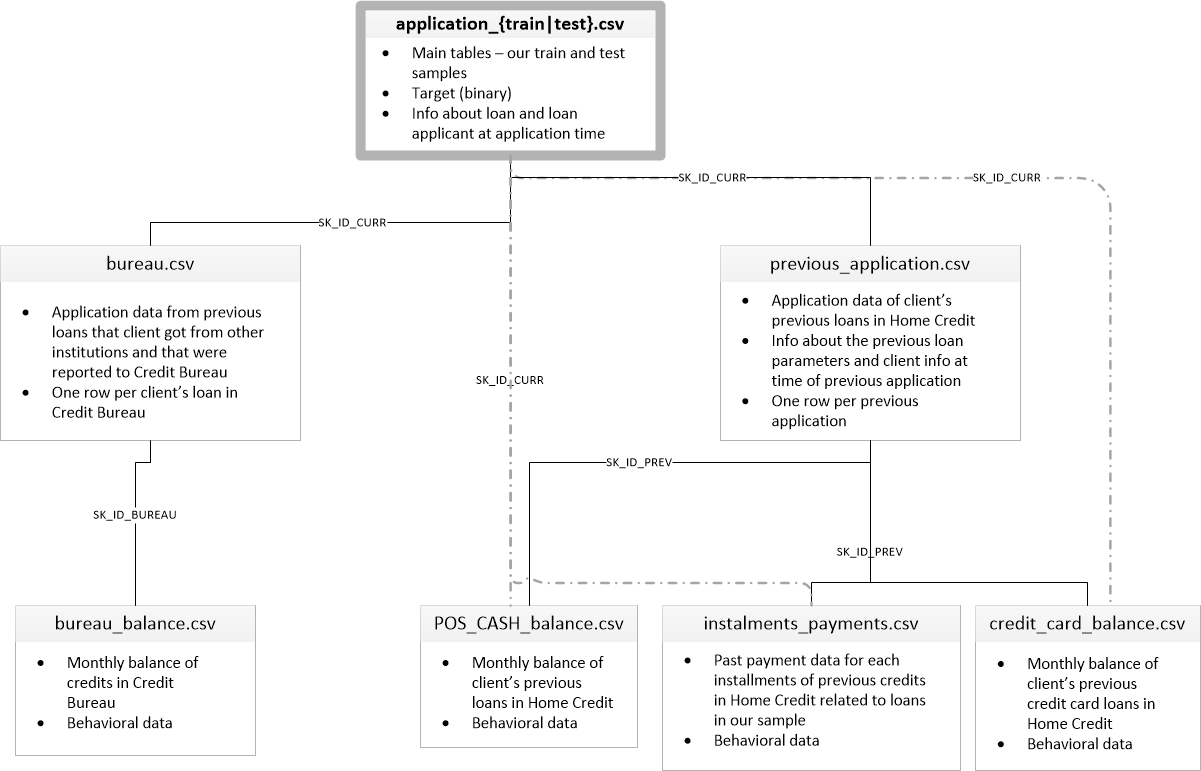

In [1]:
from IPython.display import Image
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('**This diagram shows how all of the data is related:**')
Image(filename='Downloads/home_credit.PNG',)

 # <a id='2'>2. Retrieving the Data</a>

In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt # for plotting

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
#from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline

from plotly.offline import iplot
from plotly.graph_objs import Scatter

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

%matplotlib inline

In [2]:
#Reading all the CSV files
app_train = pd.read_csv('application_train.csv')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
previous_application = pd.read_csv('previous_application.csv')
installments_payments = pd.read_csv('installments_payments.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
bureau = pd.read_csv('bureau.csv')
app_test = pd.read_csv('application_test.csv')

In [4]:
print('Size of application_train data', app_train.shape)
print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)
print('Size of bureau data', bureau.shape)

Size of application_train data (307511, 122)
Size of POS_CASH_balance data (10001358, 8)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)
Size of bureau data (1716428, 17)


 ## Number of records and Features in the datasets
 ** Let Examine the Applaication Train DataSet**

In [5]:
print("The number of Features in application train dataset :",app_train.shape[1])
print("The number of Rows in application Train dataset :",app_train.shape[0])

The number of Features in application train dataset : 122
The number of Rows in application Train dataset : 307511


In [6]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Identifying Numerical and Categorical Features

###  Function for  find out Numerical and categeical Variables

In [7]:
#Reference: https://www.kaggle.com/codename007/home-credit-complete-eda-feature-importance
def type_features(data):
    categorical_features = data.select_dtypes(include = ["object"]).columns
    numerical_features = data.select_dtypes(exclude = ["object"]).columns
    print( "categorical_features :",categorical_features)
    print('-----'*40)
    print("numerical_features:",numerical_features)
    


In [8]:
type_features(app_train)

categorical_features : Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
numerical_features: Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_

### Identifying Missing Value Present in Application Train Dataset

In [9]:

def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(15,10))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    #ms= ms[ms["Percent"] > 0]
    return ms

,Total,Percent
COMMONAREA_MEDI,33495,68.716150
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
NONLIVINGAPARTMENTS_MODE,33347,68.412523
NONLIVINGAPARTMENTS_MEDI,33347,68.412523
...,...,...
OBS_60_CNT_SOCIAL_CIRCLE,29,0.059495
DEF_60_CNT_SOCIAL_CIRCLE,29,0.059495
DEF_30_CNT_SOCIAL_CIRCLE,29,0.059495
AMT_ANNUITY,24,0.049237


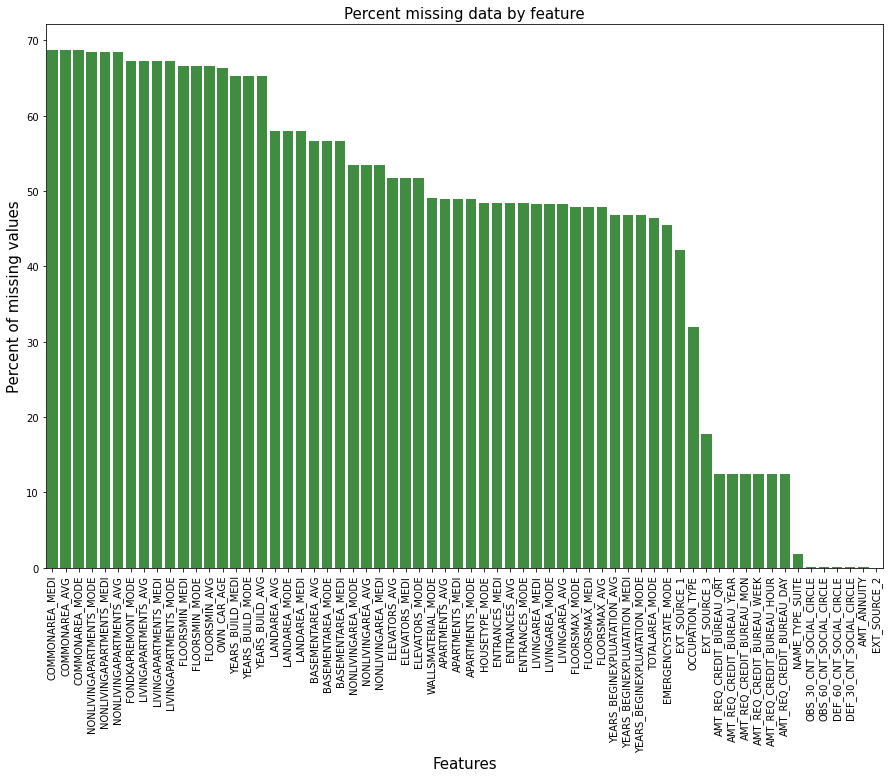

In [10]:
missingdata(app_test)

### The above given figure which clear say about the which features has missing value and precentage of missing value avaiable in application_train DataSet

### Let us Examine application_test data set

In [11]:
app_test.head(7)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,100042,Cash loans,F,Y,Y,0,270000.0,959688.0,34600.5,810000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
6,100057,Cash loans,M,Y,Y,2,180000.0,499221.0,22117.5,373500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
print("the number columns in the application_test dataset",app_test.shape[1])
print("the number rows in application_test dataset",app_test.shape[0])

the number columns in the application_test dataset 121
the number rows in application_test dataset 48744


### identifying the Catergical and numberical variables 

In [13]:
type_features(app_test)

categorical_features : Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
numerical_features: Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_

### identifying the missing values

,Total,Percent
COMMONAREA_MEDI,33495,68.716150
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
NONLIVINGAPARTMENTS_MODE,33347,68.412523
NONLIVINGAPARTMENTS_MEDI,33347,68.412523
...,...,...
OBS_60_CNT_SOCIAL_CIRCLE,29,0.059495
DEF_60_CNT_SOCIAL_CIRCLE,29,0.059495
DEF_30_CNT_SOCIAL_CIRCLE,29,0.059495
AMT_ANNUITY,24,0.049237


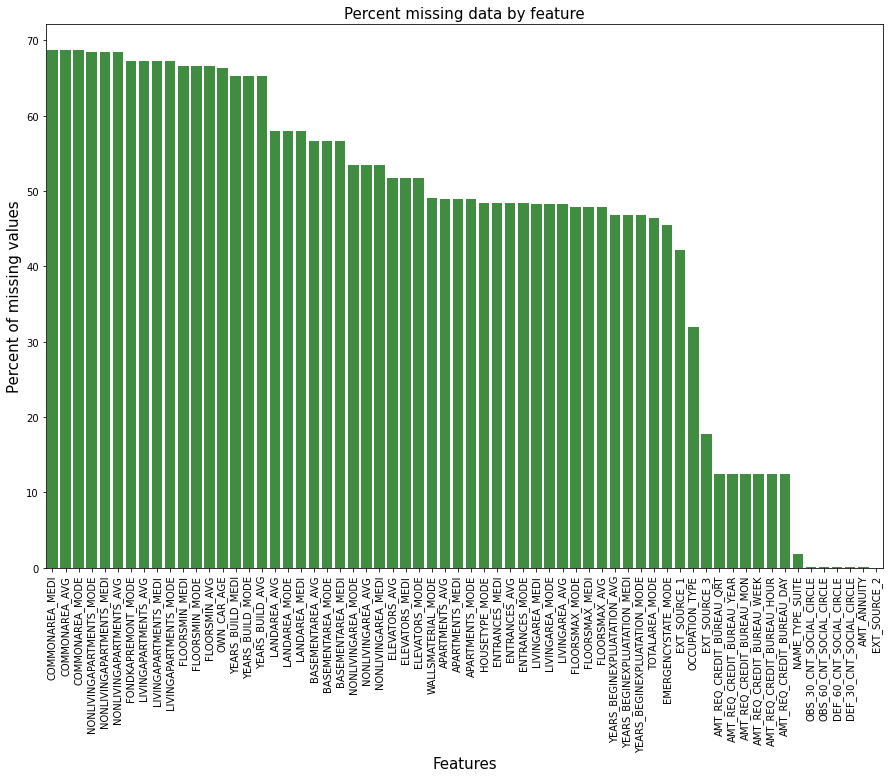

In [14]:
missingdata(app_test)

### Let Exmaine bureau dataset

In [15]:
bureau.head(6)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,Credit card,-31,NaN


In [16]:
print("The number of features is :",bureau.shape[1],"The number of row is:",bureau.shape[0])

The number of features is : 17 The number of row is: 1716428


### identifying the catergical and numnerical features  

In [17]:
type_features(bureau)

categorical_features : Index(['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], dtype='object')
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
numerical_features: Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')


### identying the missing data

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757


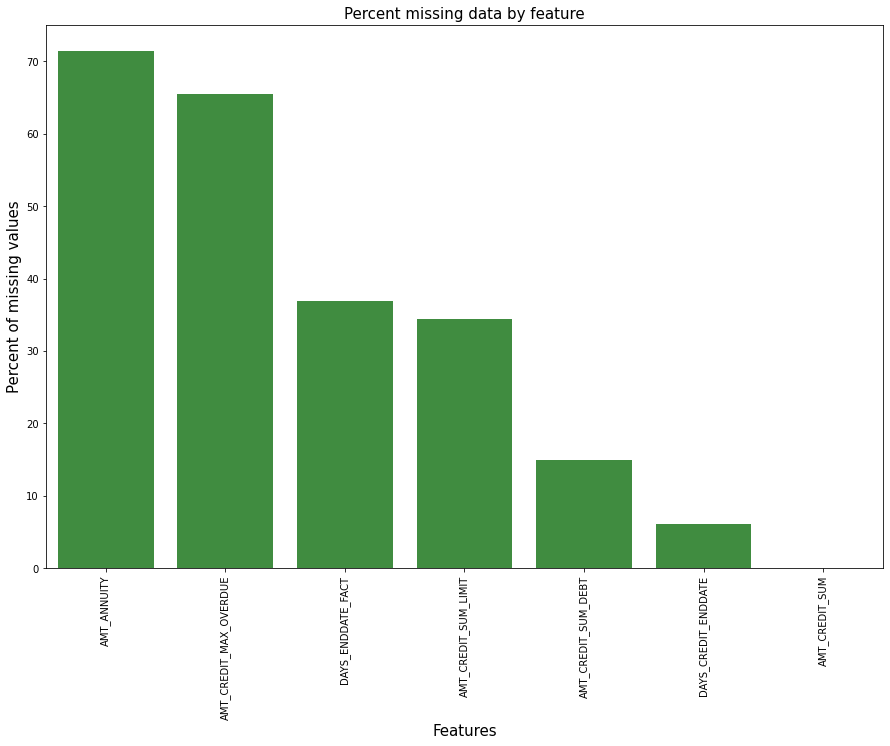

In [18]:
missingdata(bureau)

### Exmaine the bureau_balance DataSet

In [19]:
bureau_balance.head(7)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C


In [20]:
print("the number of columns",bureau_balance.shape[1],"the number of rows :",bureau_balance.shape[0])

the number of columns 3 the number of rows : 27299925


## identifying Catergical and numerical variables

In [21]:
type_features(bureau_balance)

categorical_features : Index(['STATUS'], dtype='object')
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
numerical_features: Index(['SK_ID_BUREAU', 'MONTHS_BALANCE'], dtype='object')


### identifying the missing value in bureau_balance

In [22]:
total = bureau_balance.isnull().sum().sort_values(ascending = False)
percent = (bureau_balance.isnull().sum()/bureau_balance.isnull().count()*100).sort_values(ascending = False)
ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
ms= ms[ms["Percent"] > 0]
ms

,Total,Percent


### No missing data in Bureau Balance Dataset

## Exmaine the POS_CASH_balance DataSet

In [23]:
POS_CASH_balance.head(6)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0


In [24]:
POS_CASH_balance.shape

(10001358, 8)

### identifying the Catergical and numerical variables 

In [25]:
type_features(POS_CASH_balance)

categorical_features : Index(['NAME_CONTRACT_STATUS'], dtype='object')
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
numerical_features: Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF'],
      dtype='object')


### identifying the missing values

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675


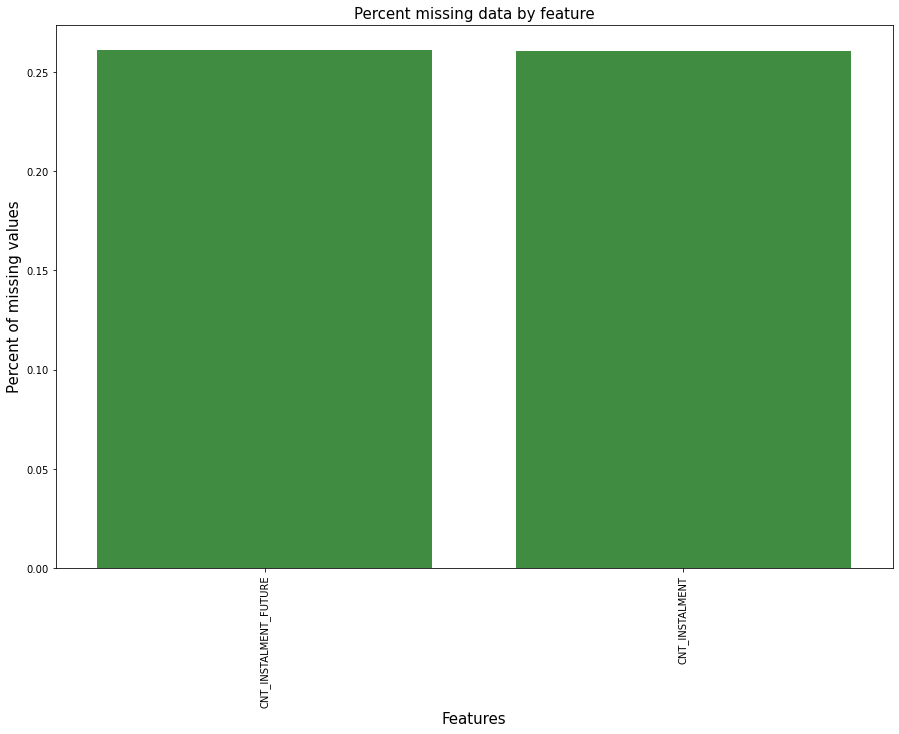

In [26]:
missingdata(POS_CASH_balance)

### Examine the credit_card_balance dataset

In [27]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [28]:
print("the number columns in dataset:",credit_card_balance.shape[1],"The number of rows:",credit_card_balance.shape[0])

the number columns in dataset: 23 The number of rows: 3840312


### identifying the Categerical and numerical Variable 

In [29]:
type_features(credit_card_balance)

categorical_features : Index(['NAME_CONTRACT_STATUS'], dtype='object')
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
numerical_features: Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF'],
      dtype='object')


### identifying the missing value in credit_card_balance dataset

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208


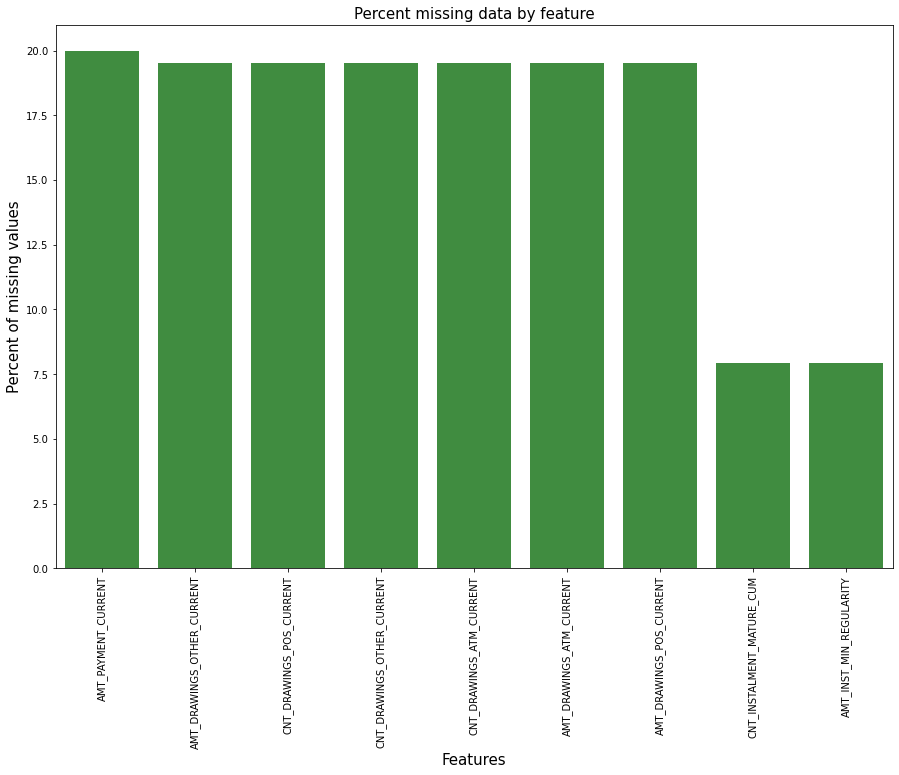

In [30]:
missingdata(credit_card_balance)

### Exmaine the previous_application Dataset

In [31]:
previous_application.head(7)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


 ### identifying the catergical and numerical variable in previous application Data set.

In [32]:
type_features(previous_application)

categorical_features : Index(['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'],
      dtype='object')
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
numerical_features: Index(['SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION',
       'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA',
       'CNT_PAYME

### identifying the missing value in previous_application

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
RATE_DOWN_PAYMENT,895844,53.636480
AMT_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
DAYS_TERMINATION,673065,40.298129
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_FIRST_DRAWING,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129


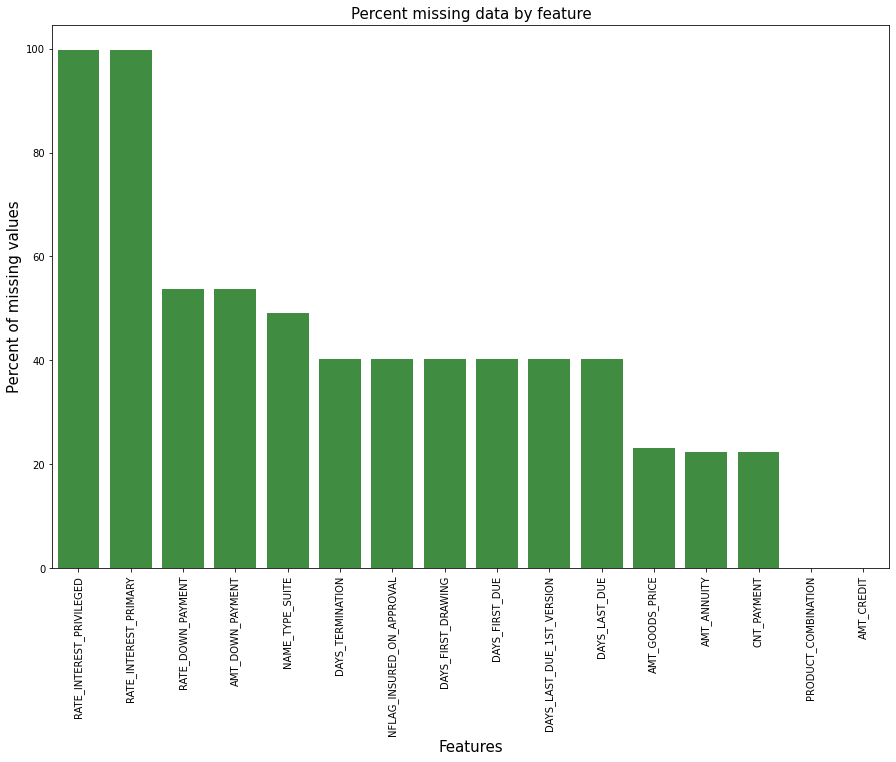

In [33]:
missingdata(previous_application)

### Exmaine the installments_payments dataset

In [34]:
installments_payments.head(7)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375
6,2234264,184693,4.0,11,-349.0,-352.0,29432.295,29432.295


### identifying the categerical and numerical Variable 

In [35]:
type_features(installments_payments)

categorical_features : Index([], dtype='object')
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
numerical_features: Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')


### identifying the missing value in installments_payments

,Total,Percent
AMT_PAYMENT,2905,0.021352
DAYS_ENTRY_PAYMENT,2905,0.021352


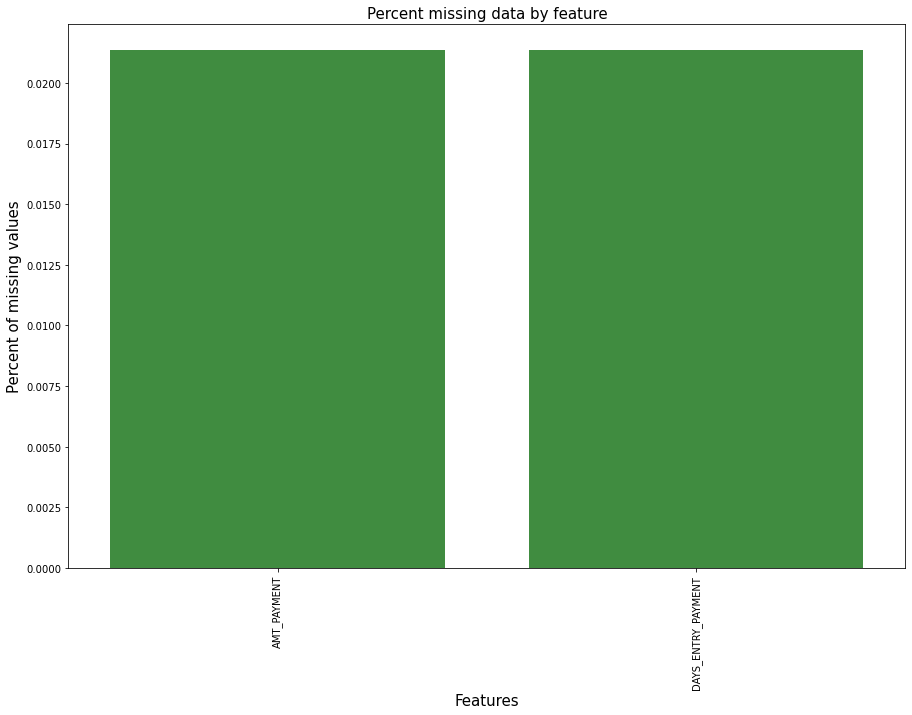

In [36]:
missingdata(installments_payments)

## Checking the Imbalance of Target Variable

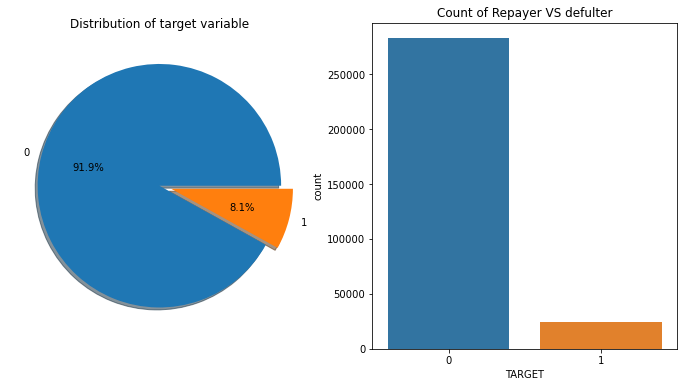

In [37]:
f,ax=plt.subplots(1,2,figsize=(12,6))
app_train.TARGET.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Distribution of target variable')
ax[0].set_ylabel('')
sns.countplot('TARGET',data=app_train,ax=ax[1])
ax[1].set_title('Count of Repayer VS defulter')
plt.show()

It is evident that  many customer are able to pay the loan back i.e Only 91.9% of the total customer are repaying the loan.
We need to drill down more to get better insights from the data and see which categories of the customer are not able to pay back loan.

We will try to check the repayer and defualter rate by using the different features of the dataset. 
Some of the features being Gender,Education,Employment_type,etc. First let us understand the different types of features.

## Types Of Features

### Categorical Features:
A categorical variable is one that has two or more categories and each value in that feature can be categorised by them.For example, 
Name Education Type is a categorical variable having Five categories. Now we cannot sort or give any ordering to such variables. They are also known as Nominal Variables.

Categorical Features in the dataset: Education_type,occupation_type,Contract_type

### Analysing The Features
***Eduaction-----> Categorical Feature***

In [38]:
def group_by(df,t1='',t2=''):
    a1=df.groupby([t1,t2])[t2].count()
    return a1

In [39]:
def plot_re(df,t1='',t2=''):
    f,ax=plt.subplots(1,2,figsize=(10,6))
    df[[t1,t2]].groupby([t1]).count().plot.bar(ax=ax[0],color='Green')
    ax[0].set_title('count of customer Based on'+t1)
    sns.countplot(t1,hue=t2,data=df,ax=ax[1],palette="spring")
    ax[1].set_title(t1+': Repayer vs Defualter')
    # Rotate x-labels
    plt.xticks(rotation=-90)
    a=plt.show()
    return a

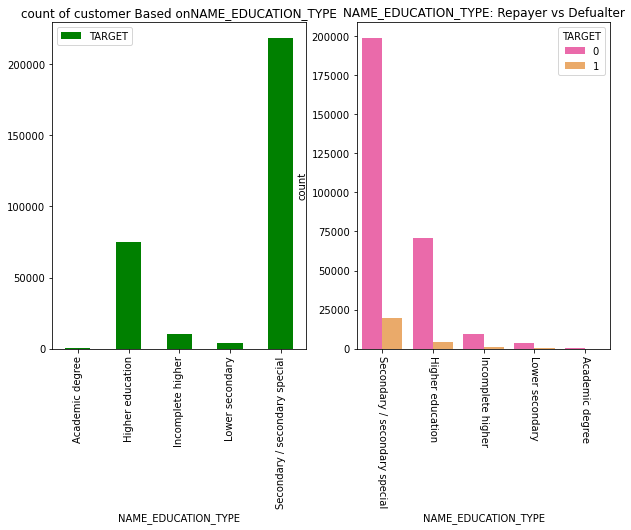

In [40]:
plot_re(app_train,'NAME_EDUCATION_TYPE','TARGET')

### the proof is  edvined by looking at the above given plot and groupby function is clearly customer with education of secondary/secondary special has high  count where not able to pay loan back.

## Analysis based on Code  Gender 

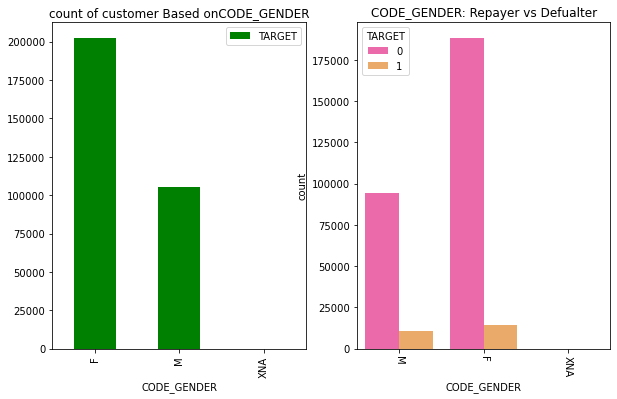

In [41]:
plot_re(app_train,'CODE_GENDER','TARGET')

### its clear that  by looking at the above given plot and groupby function is clearly customer based on code gender type female  has high  count where not able to pay loan back compare to male.

### Analysis based on INCOME TYPE

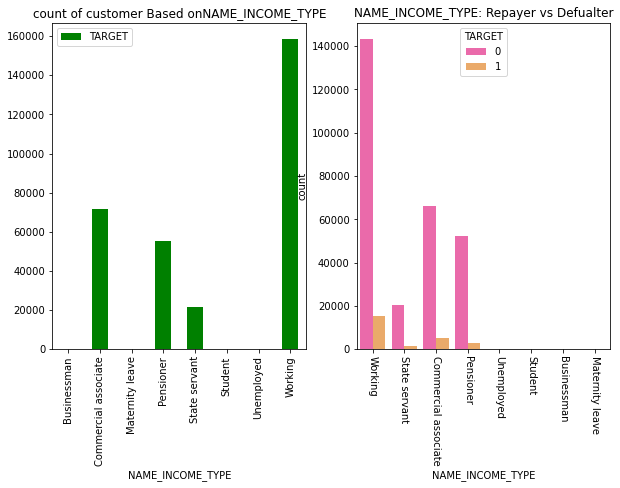

In [42]:
plot_re(app_train,'NAME_INCOME_TYPE','TARGET')

### its clear that  by looking at the above given plot and groupby function is clearly customer based on code income type and the working  has high  count where not able to pay loan back compare to all other

### Analysis based on OCCUPATION TYPE

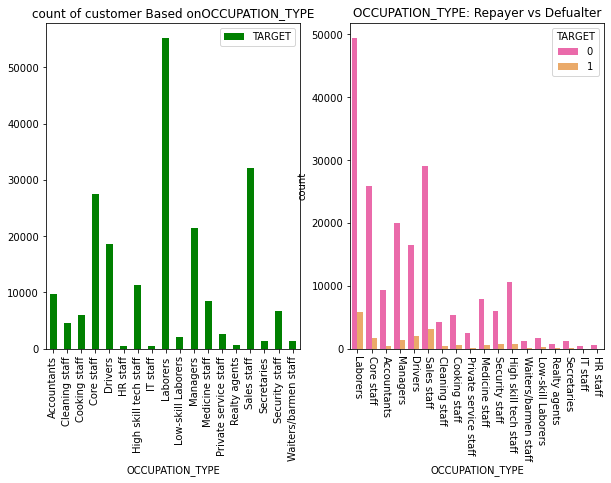

In [43]:
plot_re(app_train,'OCCUPATION_TYPE','TARGET')

###  its clear that  by looking at the above given plot and groupby function is clearly customer based on occupation  type. the working  has high  count where not able to pay loan back compare to all other.

### Analysis Based on FAMILY STATUS

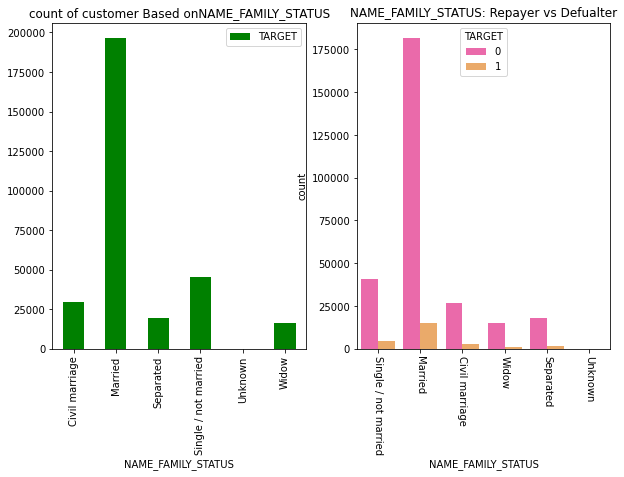

In [44]:
plot_re(app_train,'NAME_FAMILY_STATUS','TARGET')

### its clear that  by looking at the above given plot and groupby function is clearly customer based on code Family type and the Married customer  has high  count where not able to pay loan back compare to all other.


### Analysis based HOUSING TYPE

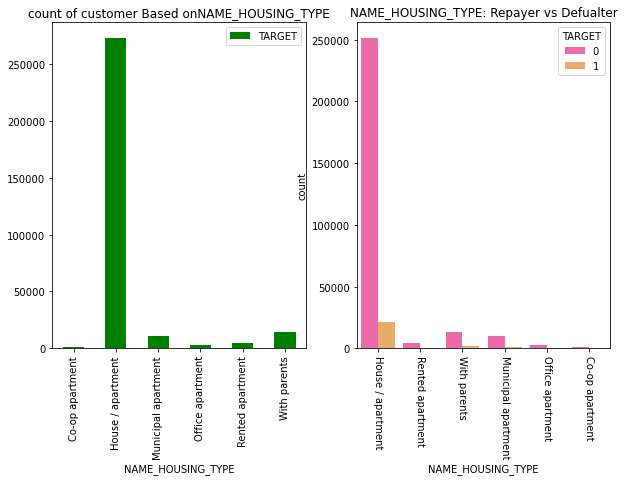

In [45]:
plot_re(app_train,'NAME_HOUSING_TYPE','TARGET')

### its clear that  by looking at the above given plot and groupby function is clearly customer based on Housing type and the house type customer  has high  count where not able to pay loan back compare to all other.

### Analysis based on TYPE SUITE

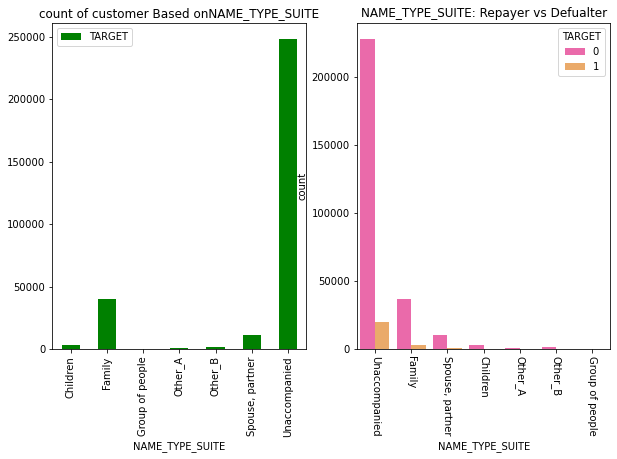

In [46]:
plot_re(app_train,'NAME_TYPE_SUITE','TARGET')

### its clear that  by looking at the above given plot and groupby function is clearly customer based on Suite type and the unaccompanied customer  has high  count where not able to pay loan back compare to all other.

### Analysis Based on ORGANIZATION TYPE

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57]),
 <a list of 58 Text major ticklabel objects>)

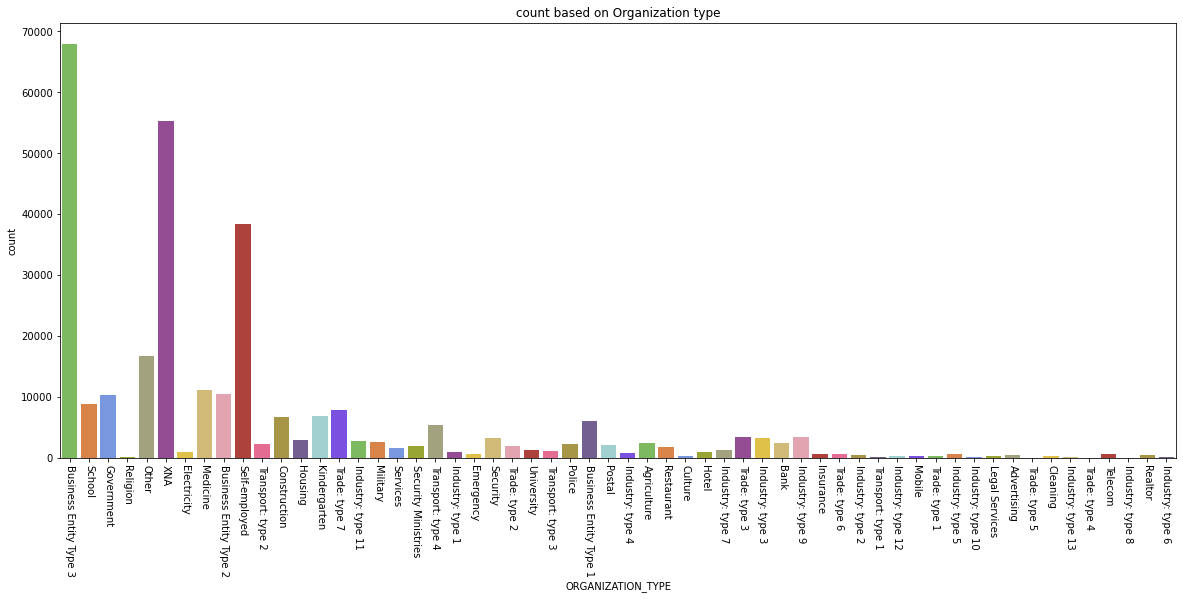

In [47]:
f, ax = plt.subplots(figsize=(20, 8))
# Employee distri
# Types of colors
color_types = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878','#A040A0','#F8D030',  
                '#E0C068','#EE99AC','#C03028','#F85888','#B8A038','#705898','#98D8D8','#7038F8']

# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='ORGANIZATION_TYPE', data=app_train, palette=color_types).set_title('count based on Organization type');
 
# Rotate x-labels
plt.xticks(rotation=-90)

Text(0.5, 1.0, 'REpayer VS Defaulter based on Organization type')

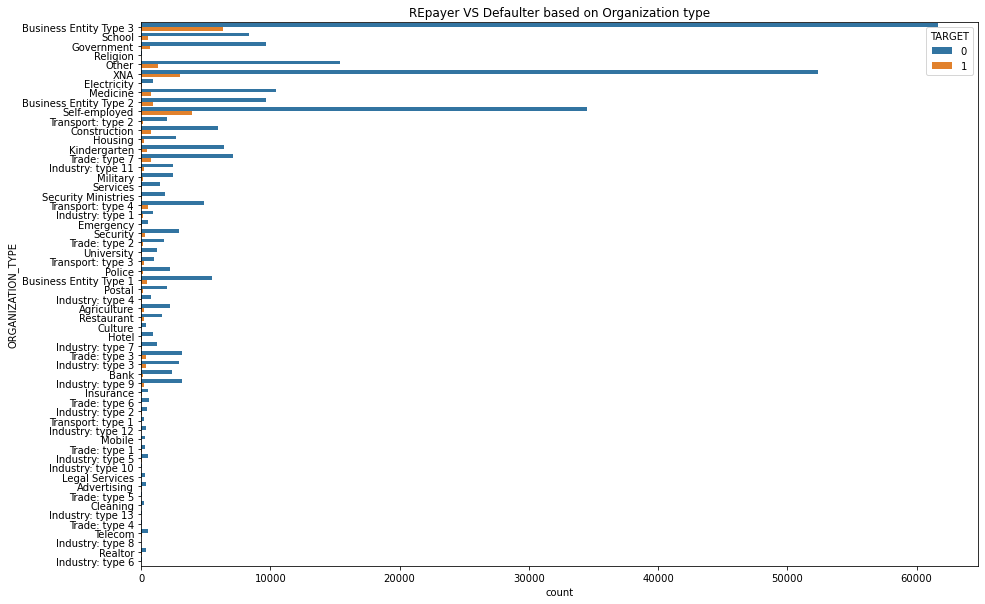

In [48]:
f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y="ORGANIZATION_TYPE", hue='TARGET', 
              data=app_train).set_title('REpayer VS Defaulter based on Organization type')

### its clear that  by looking at the above given plot and groupby function is clearly customer based on Organization type and the Business type 3 customer  has high  count where not able to pay loan back compare to all other.

### Analysis based on FLAG OWN CAR

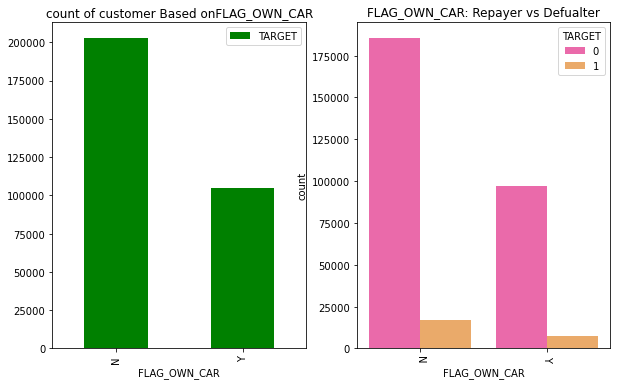

In [49]:
plot_re(app_train,'FLAG_OWN_CAR','TARGET')

### its clear that  by looking at the above given plot and groupby function is clearly customer based on owning car type and the customer with no car  has high  count where not able to pay loan back compare to all other.

### Analysis based on FLAG_OWN_REALTY

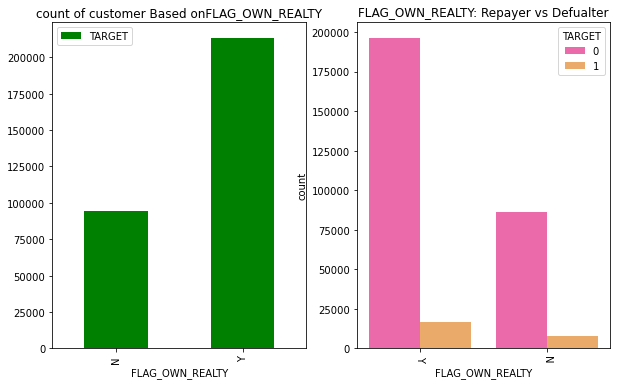

In [50]:
plot_re(app_train,'FLAG_OWN_REALTY','TARGET')

### its clear that  by looking at the above given plot and groupby function is clearly customer based on owning Reality type and the customer has Reality  has high  count where not able to pay loan back compare to all other.

### Analysis based on NAME_CONTRACT_TYPE

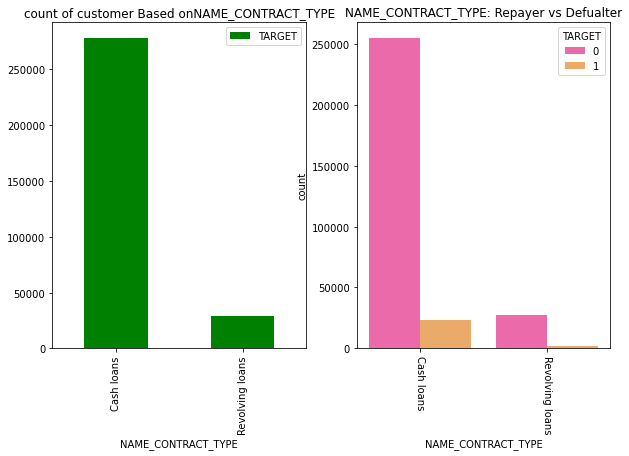

In [51]:
plot_re(app_train,'NAME_CONTRACT_TYPE','TARGET')

### its clear that  by looking at the above given plot and groupby function is clearly customer based on Contract type and the customer with cash loans  has high  count where not able to pay loan back compare to all other.

### Analysis based on WEEKDAY_APPR_PROCESS_START

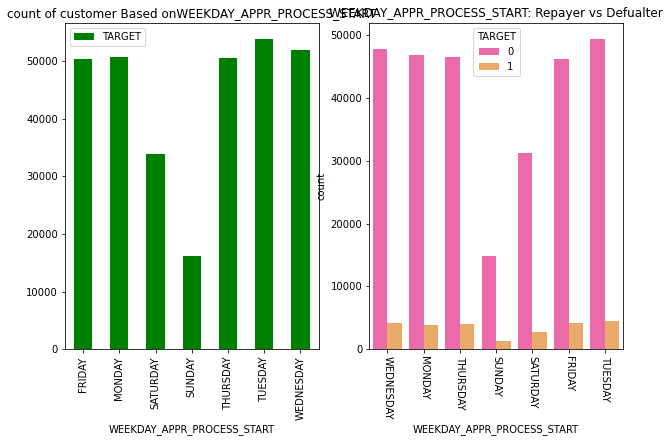

In [52]:
plot_re(app_train,'WEEKDAY_APPR_PROCESS_START','TARGET')

### its clear that  by looking at the above given plot and groupby function is clearly customer based application start on days and the customer registed  on tuesday  has high  count were not able to pay loan back compare to all other.

### Analysis based House Type Mode

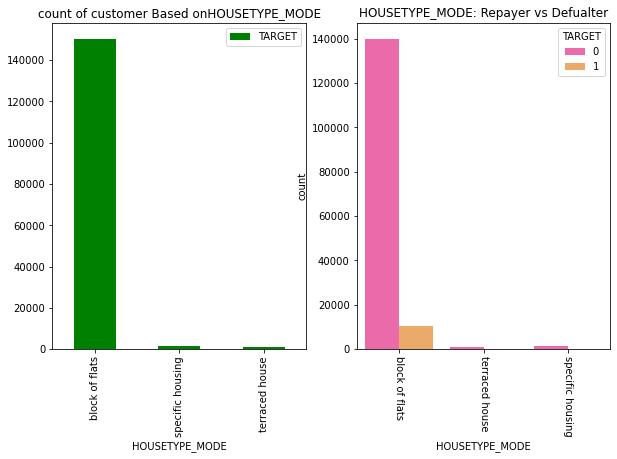

In [53]:
plot_re(app_train,'HOUSETYPE_MODE','TARGET')

### its clear that  by looking at the above given plot and groupby function is clearly customer based Housetype Mode and the customer registed  on Block of flats has high  count where not able to pay loan back compare to all other.

### Analysis Based on EMERGENCYSTATE MODE 

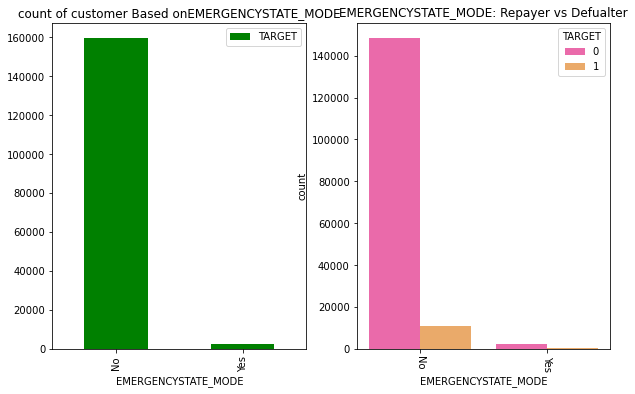

In [54]:
plot_re(app_train,'EMERGENCYSTATE_MODE','TARGET')

### its clear that  by looking at the above given plot and groupby function is clearly customer based Emergency state Mode and the customer has No  has high  count where not able to pay loan back compare to all other.

### ANALYSIS THE NUMBERICAL FEATURES 


#### ANALYZSIS BASED ON  COUNT CHILDREN 

Text(0.5, 1.0, 'Children count Distribution - Repayer V.S. Non Repayers')

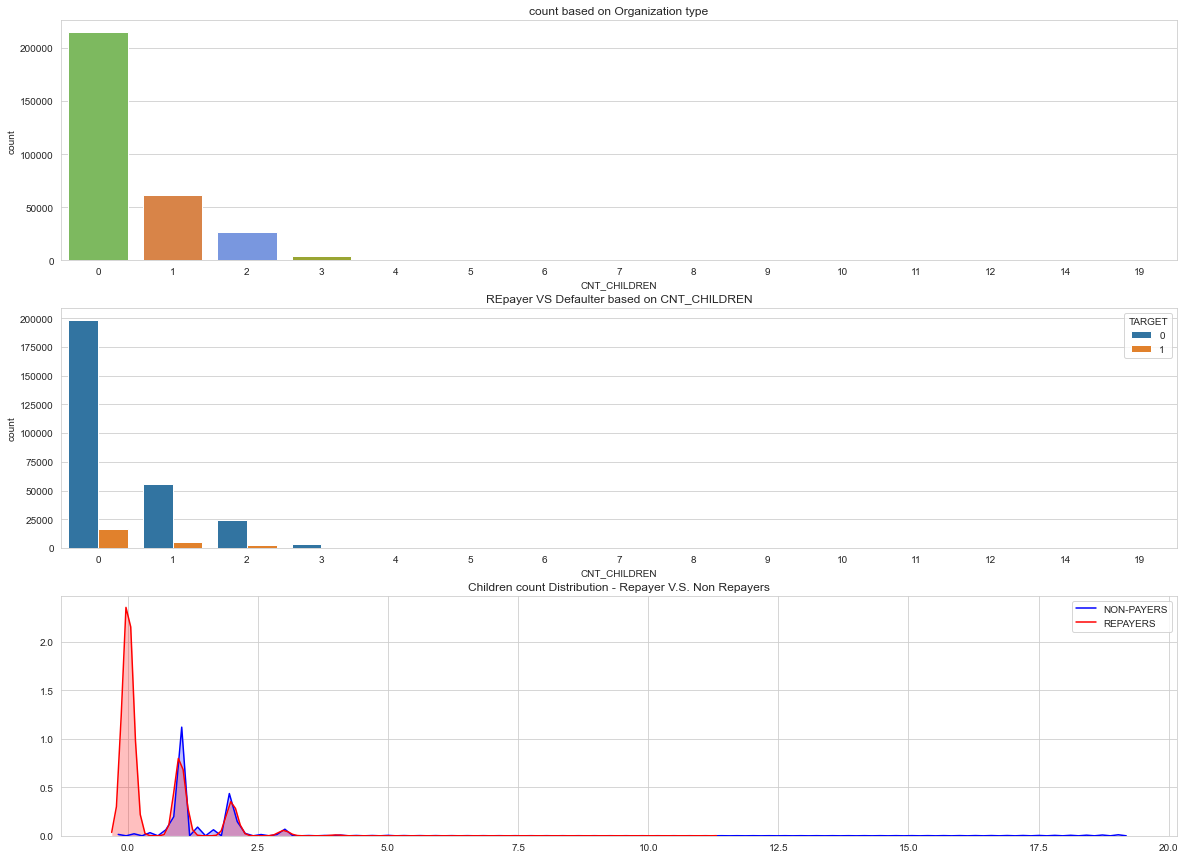

In [55]:
sns.set_style('whitegrid')
f, ax = plt.subplots(3,1,figsize=(20,15))

# Types of colors
color_types = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878','#A040A0','#F8D030',  
                '#E0C068','#EE99AC','#C03028','#F85888','#B8A038','#705898','#98D8D8','#7038F8']

# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='CNT_CHILDREN', data=app_train, ax=ax[0],palette=color_types).set_title('count based on Organization type');
sns.countplot("CNT_CHILDREN", hue='TARGET', 
              data=app_train,ax=ax[1]).set_title('REpayer VS Defaulter based on CNT_CHILDREN')
ax[2]=sns.kdeplot(app_train.loc[(app_train['TARGET'] == 0),'CNT_CHILDREN'] , color='b',shade=True,label='NON-PAYERS')
ax[2]=sns.kdeplot(app_train.loc[(app_train['TARGET'] == 1),'CNT_CHILDREN'] , color='r',shade=True, label='REPAYERS')
ax[2].set_title('Children count Distribution - Repayer V.S. Non Repayers')


its clear that  by looking at the above given plots and groupby function is clearly customer based count of children and the customer with   has No  children has high  count and customer with more than  8   50% of non payer based on it own count where not able to pay loan back compare to all other.

Text(0.5, 1.0, 'customer Amount Annual income Distribution')

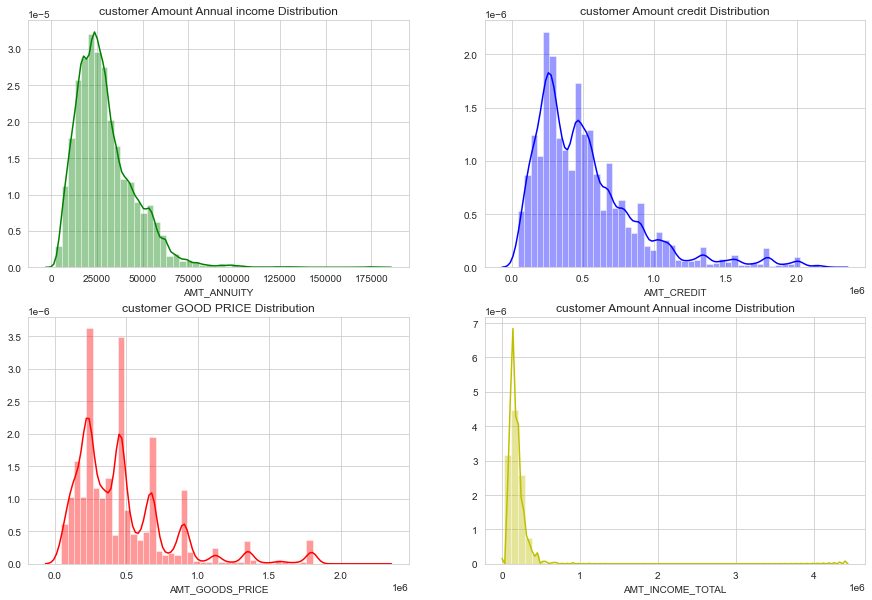

In [56]:
# Set up the matplotlib figure
f, ax = plt.subplots(2,2, figsize=(15, 10))

# Graph amt annutiy Satisfaction
sns.distplot(app_test.AMT_ANNUITY.dropna(), kde=True, color="g", ax=ax[0,0]).set_title('customer Amount Annual income Distribution')


# Graph amt credit Evaluation
sns.distplot(app_test.AMT_CREDIT.dropna(), kde=True, color="b", ax=ax[0,1]).set_title('customer Amount credit Distribution')

# Graph anaual GOOD PRICE  
sns.distplot(app_test.AMT_GOODS_PRICE.dropna(), kde=True, color="r", ax=ax[1,0]).set_title('customer GOOD PRICE Distribution')


sns.distplot(app_test.AMT_INCOME_TOTAL.dropna(), kde=True, color="y", ax=ax[1,1]).set_title('customer Amount Annual income Distribution')



### if we see  the above given distrbution plot it clear say major distrbuiton  for amouth annuity is from 0 to 75000 and amount of anual income is from 0 to 1000000

Text(0.5, 1.0, 'customer Days of Registration Distribution')

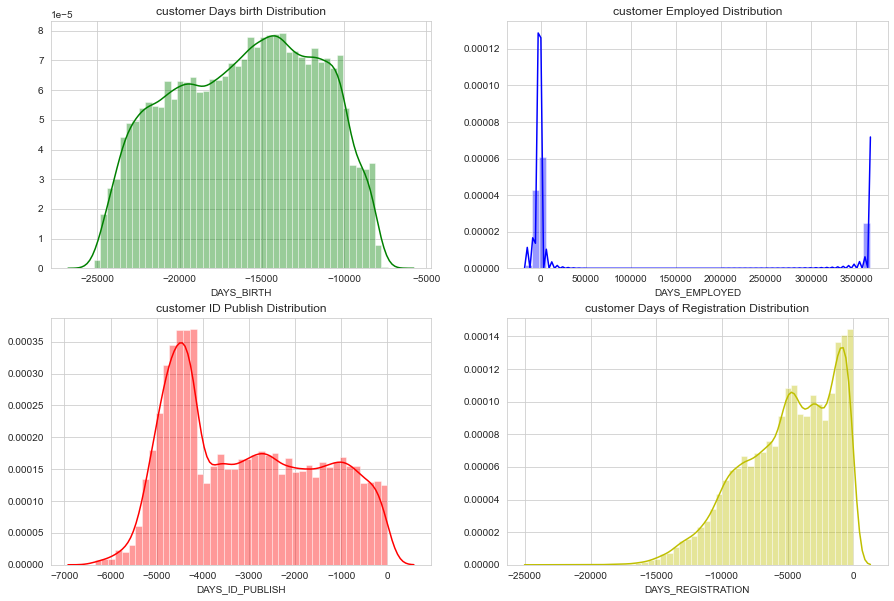

In [57]:
sns.set_style('whitegrid')
# Set up the matplotlib figure
f, ax = plt.subplots(2,2, figsize=(15, 10))

# Graph amt annutiy Satisfaction
sns.distplot(app_test.DAYS_BIRTH.dropna(), kde=True, color="g", ax=ax[0,0]).set_title('customer Days birth Distribution')

sns.distplot(app_test.DAYS_EMPLOYED.dropna(), kde=True, color="b", ax=ax[0,1]).set_title('customer Employed Distribution')

sns.distplot(app_test.DAYS_ID_PUBLISH.dropna(), kde=True, color="r", ax=ax[1,0]).set_title('customer ID Publish Distribution')


sns.distplot(app_test.DAYS_REGISTRATION.dropna(), kde=True, color="y", ax=ax[1,1]).set_title('customer Days of Registration Distribution')


#### Analysis based on   REGION_RATING_CLIENT , REGION_RATING_CLIENT_W_CITY', HOUR_APPR_PROCESS_STAR',
  REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
  LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY
 REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'

if we look at the above plot it is clear that customer register in city but not work in city based analysis we know that customer not city has high count.

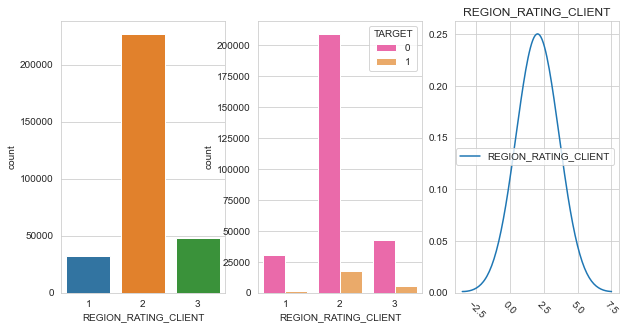

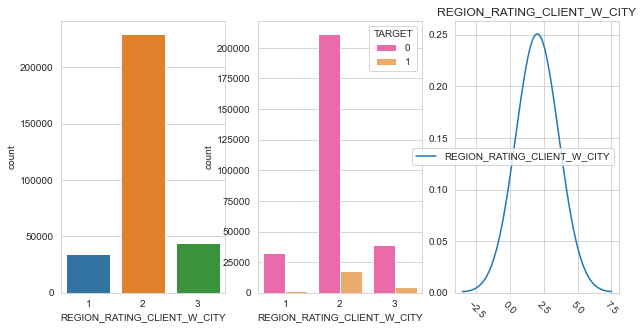

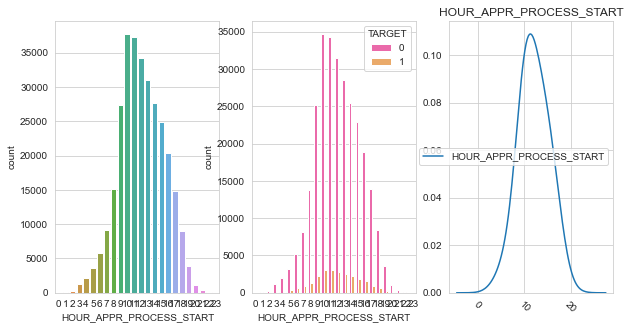

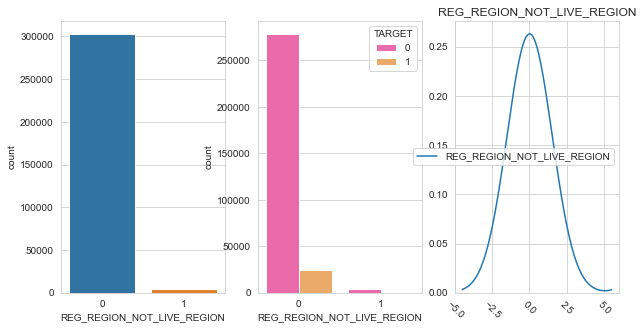

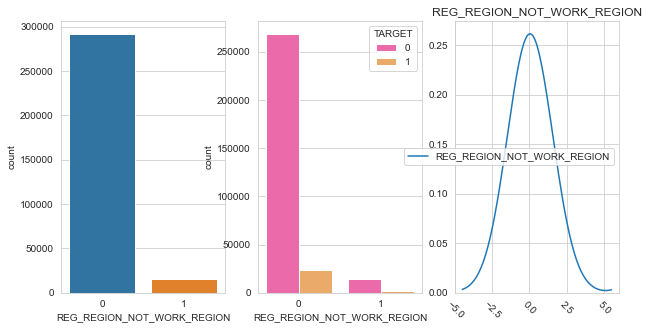

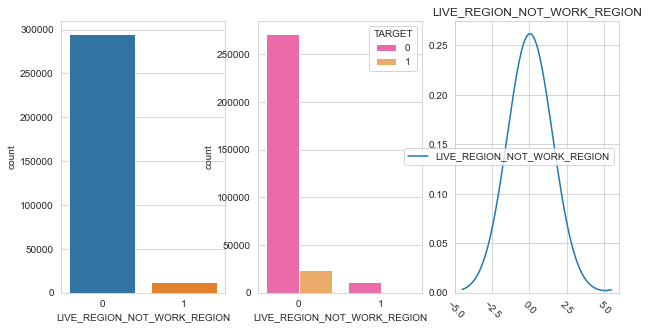

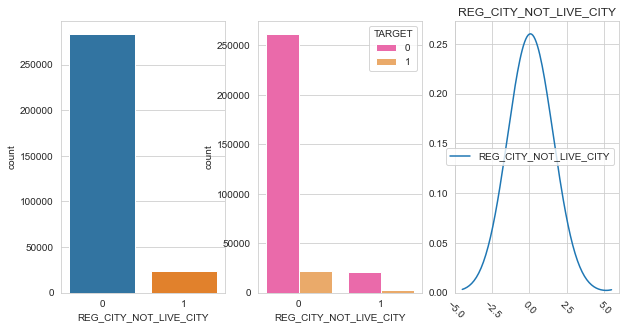

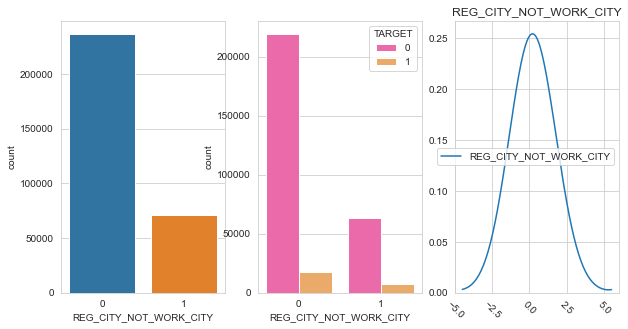

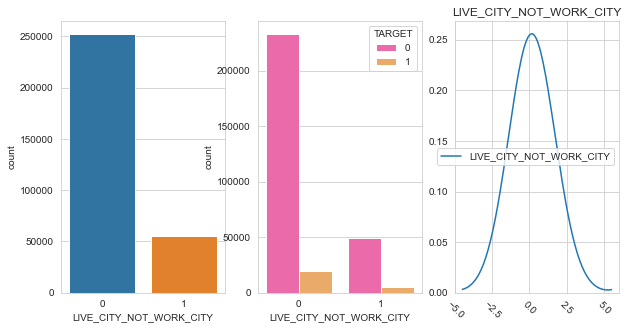

In [58]:
import statsmodels
visual_dat= ['REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']


for i in visual_dat:
    plt.figure(figsize = (10,5))
    plt.subplot(1,3,1)
    sns.countplot(app_train[i])
    plt.subplot(1,3,2)
    sns.countplot(app_train[i],hue=app_train['TARGET'],palette="spring")
    plt.subplot(1,3,3)
    sns.kdeplot(app_train[i],bw=1.5) 
    plt.title(i)
    plt.xticks(rotation=-45)
    plt.show()
    


### By looking at the above given we can clear get id of which loan Repayer vs NOn Payer  all features list in above plot

1. 1. ### Analysis Based on EXter Source Types

Text(0.5, 1.0, 'EXt Source 3 Distribution')

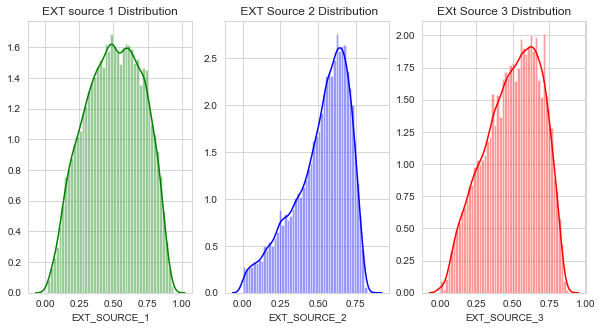

In [59]:
# Set up the matplotlib figure
f, ax = plt.subplots(ncols=3,figsize=(10, 5))


sns.distplot(app_test.EXT_SOURCE_1.dropna(), kde=True, color="g", 
             ax=ax[0]).set_title('EXT source 1 Distribution')



sns.distplot(app_test.EXT_SOURCE_2.dropna(), kde=True, color="b",
             ax=ax[1]).set_title(' EXT Source 2 Distribution')

 
sns.distplot(app_test.EXT_SOURCE_3.dropna(), kde=True, 
             color="r", ax=ax[2]).set_title('EXt Source 3 Distribution')




### Analysis based Averages values

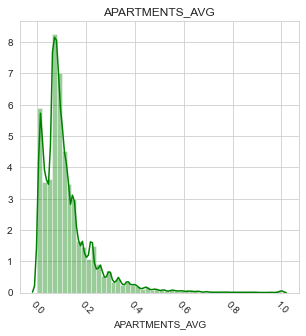

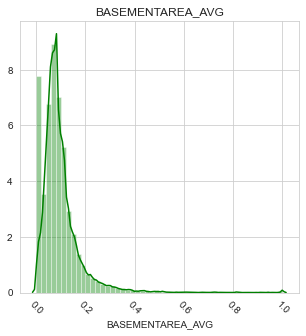

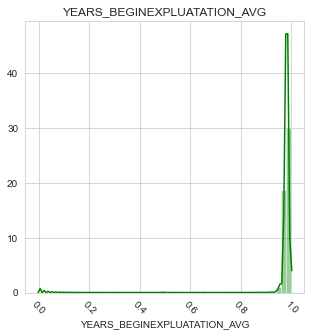

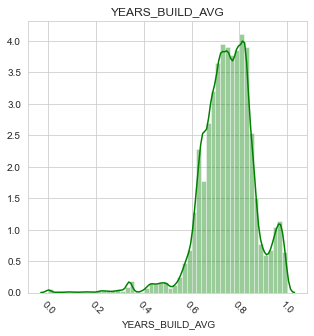

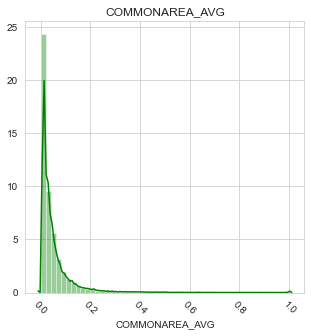

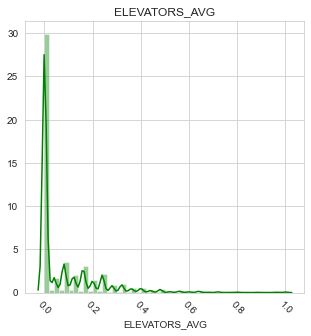

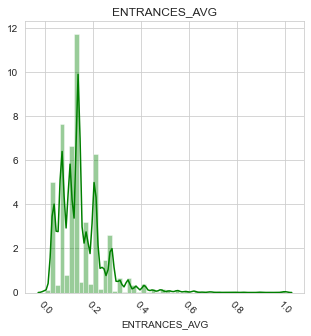

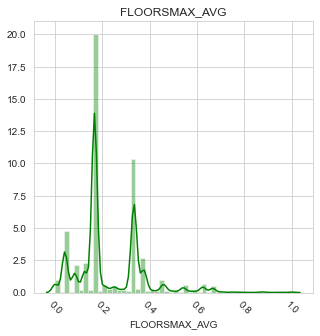

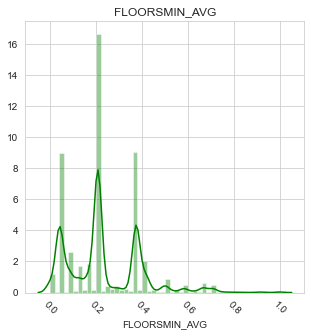

In [60]:
val_p=['APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG']
#color_types = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878','#A040A0','#F8D030',  
 #               '#E0C068','#EE99AC','#C03028','#F85888','#B8A038','#705898','#98D8D8','#7038F8']
for i in val_p:
    plt.figure(figsize = (5,5))
    sns.distplot(app_train[i].dropna(), kde=True, color='g')        
    plt.title(i)
    plt.xticks(rotation=-45)
    plt.show()
    

## <a > Distribution of AMT_CREDIT</a>

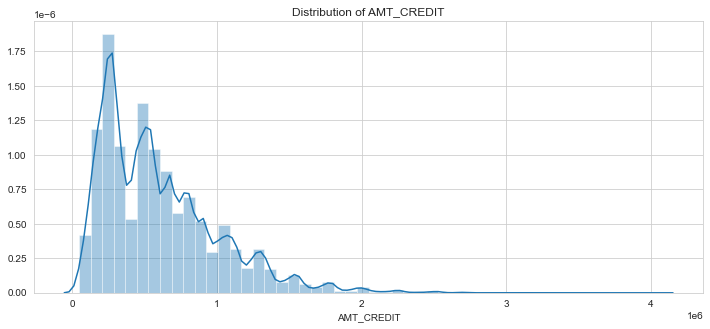

In [61]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(app_train["AMT_CREDIT"])

## <a > Distribution of AMT_INCOME_TOTAL</a>

In [62]:
(app_train[app_train['AMT_INCOME_TOTAL'] > 1000000]['TARGET'].value_counts())/len(app_train[app_train['AMT_INCOME_TOTAL'] > 1000000])*100

0    94.8
1     5.2
Name: TARGET, dtype: float64

## <a > Distribution of AMT_GOODS_PRICE</a>

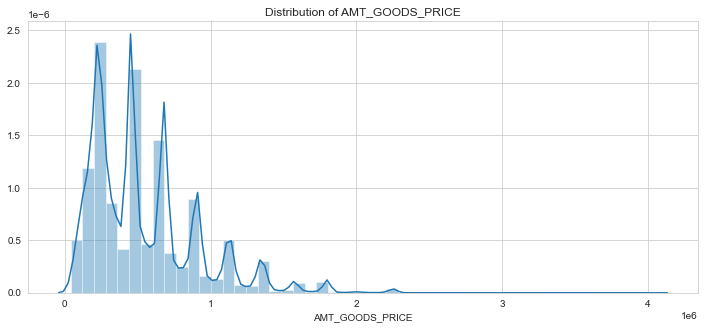

In [63]:
%matplotlib inline
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(app_train["AMT_GOODS_PRICE"].dropna())

## Bureau data
* Bureau data contains all client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in the sample). For every loan in the sample, there are as many rows as number of credits the client had in Credit Bureau before the application date. SK_ID_CURR is the key connecting application_train|test data with bureau data.

* Let's merge application_train with bureau.

In [64]:
app_bureau_train = app_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [65]:
print("The resulting dataframe `application_bureau_train` has ",app_bureau_train.shape[0]," rows and ", 
      app_bureau_train.shape[1]," columns.")

The resulting dataframe `application_bureau_train` has  1465325  rows and  138  columns.


### Let's now analize the application_bureau_train data.

In [66]:
def plot_b_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_bureau_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_bureau_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

### Credit status
* Let's see the credit status distribution. We show first the number of credits per category (could be Closed, Active, Sold and Bad debt).

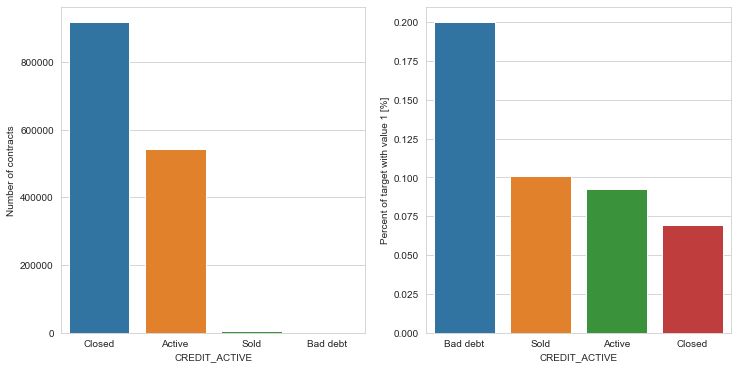

In [67]:
plot_b_stats('CREDIT_ACTIVE')

* Most of the credits registered at the Credit Bureau are in the status Closed (~900K). On the second place are the Active credits ( a bit under 600K). Sold and Bad debt are just a few.

* In the same time, as percent having TARGET = 1 from total number per category, clients with credits registered to the Credit Bureau with Bad debt have 20% default on the currrent applications.

* Clients with credits Sold, Active and Closed have percent of TARGET == 1 (default credit) equal or less than 10% (10% being the rate overall). The smallest rate of default credit have the clients with credits registered at the Credit Bureau with Closed credits.

## Credit currency
* Let's check now the number of credits registered at the Credit Bureau with different currencies. Also, let's check procent of defaulting credits (for current applications) per different currencies of credits credits registered at the Credit Bureau in the past for the same client.

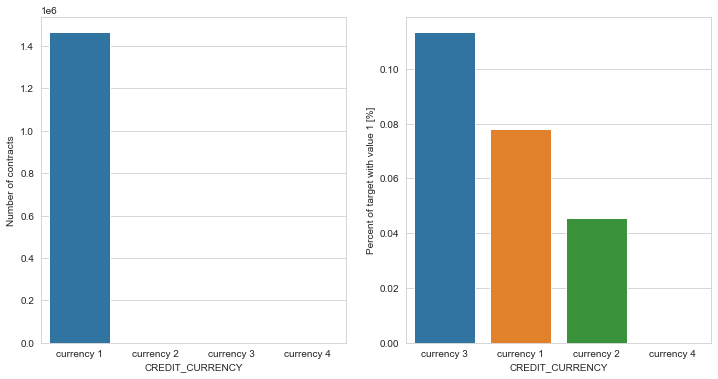

In [68]:
plot_b_stats('CREDIT_CURRENCY')

* Credits are mostly in currency_1.

* Depending on the currency, the percent of clients defaulting is quite different. Starting with currency_3, then currency_1 and currency_2, the percent of clients defaulting is 11%, 8% and 5%. Percent of defaulting applications for clients that have credits registered with currency_4 is close to 0.

## Credit type
* Let's check now the credit types for credits registered at the Credit Bureau.

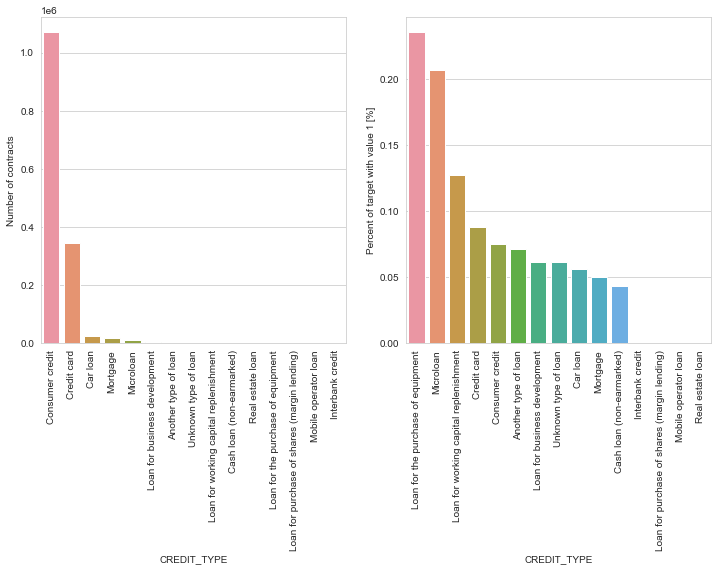

In [69]:
plot_b_stats('CREDIT_TYPE', True, True)

 Majority of historical credits registered at the Credit Bureau are Consumer credit and Credit card. Smaller number of credits are Car loan, Mortgage and Microloan.

 Looking now to the types of historical credits registered at the Credit Bureau, there are few types with a high percent of current credit defaults, as following:

  - Loan for the purchase of equipment - with over 20% current credits defaults;
  - Microloan - with over 20% current credits defaults;
  - Loan for working capital replenishement - with over 12% current credits defaults.

## Duration of credit (DAYS_CREDIT)
 Let's check the distribution of number of days for the credit (registered at the Credit bureau).

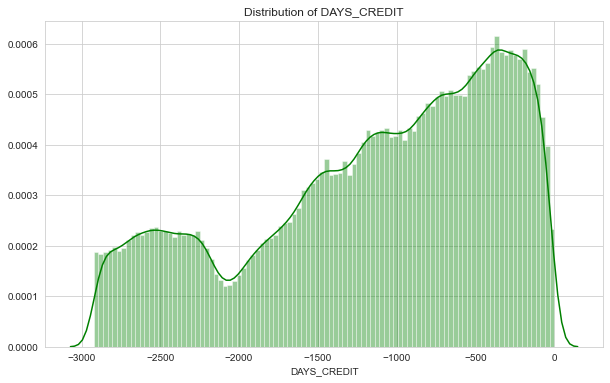

In [70]:
def plot_b_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(app_bureau_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show() 
    
plot_b_distribution('DAYS_CREDIT','green')

The credit duration (in days) is ranging between less than 3000 days (with a local sadle around 2000 days) and with a increasing frequence for shorter number of days - and with a peak around 300 days (or less than one year).

## Credit sum (AMT_CREDIT_SUM)

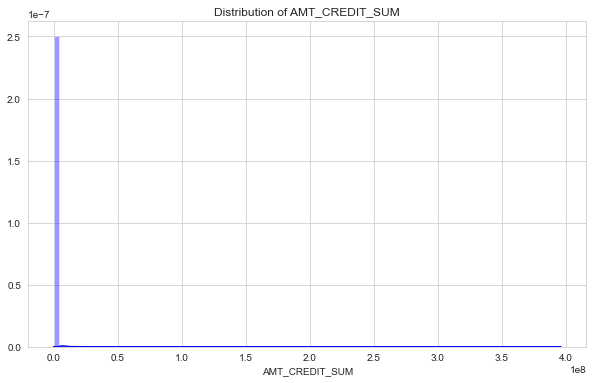

In [71]:
plot_b_distribution('AMT_CREDIT_SUM','blue')

The distribution of the AMT_CREDIT_SUM shows a concentration of the credits for the lower credit sum range.

Let's remove the outliers so that we can see better the distribution around 0.

Let's introduce a function to identify and filter the outliers (with a predefined threshold).

Then, let's also modify the function to display a distribution, this time by using the function to filter the outliers.

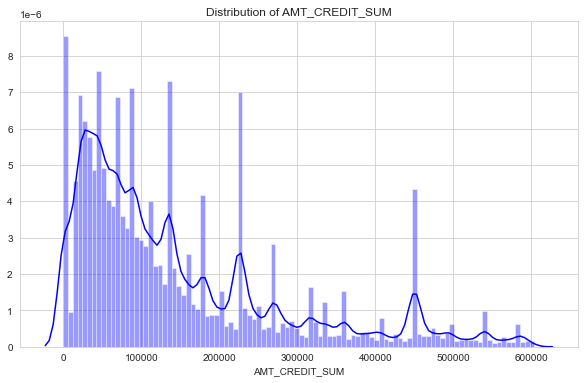

In [72]:
# Source: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting (see references)

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def plot_b_o_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    x = app_bureau_train[feature].dropna()
    filtered = x[~is_outlier(x)]
    sns.distplot(filtered,color=color, kde=True,bins=100)
    plt.show() 

plot_b_o_distribution('AMT_CREDIT_SUM','blue')

We can observe that the distribution function shows several peaks and the maximum concentration of the values is around 20,000 but we also see several other peaks at higher values.

## Credit sum limit (AMT_CREDIT_SUM_LIMIT)

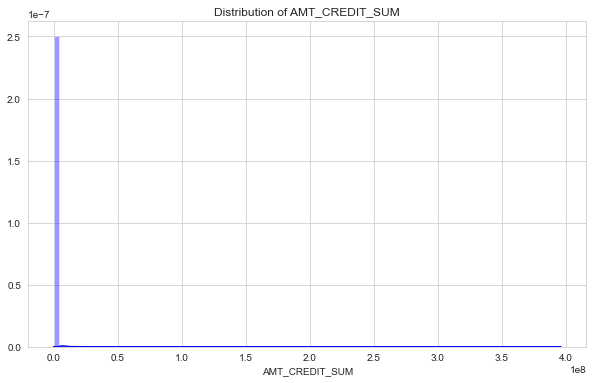

In [73]:
plot_b_distribution('AMT_CREDIT_SUM','blue')

Comparison of interval values with TARGET = 1 and TARGET = 0
Let's compare the distribution of interval values ploted above for values of TARGET = 1 and TARGET = 0

In [74]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_b_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = app_bureau_train.loc[app_bureau_train['TARGET'] != 0]
    t0 = app_bureau_train.loc[app_bureau_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

<Figure size 432x288 with 0 Axes>

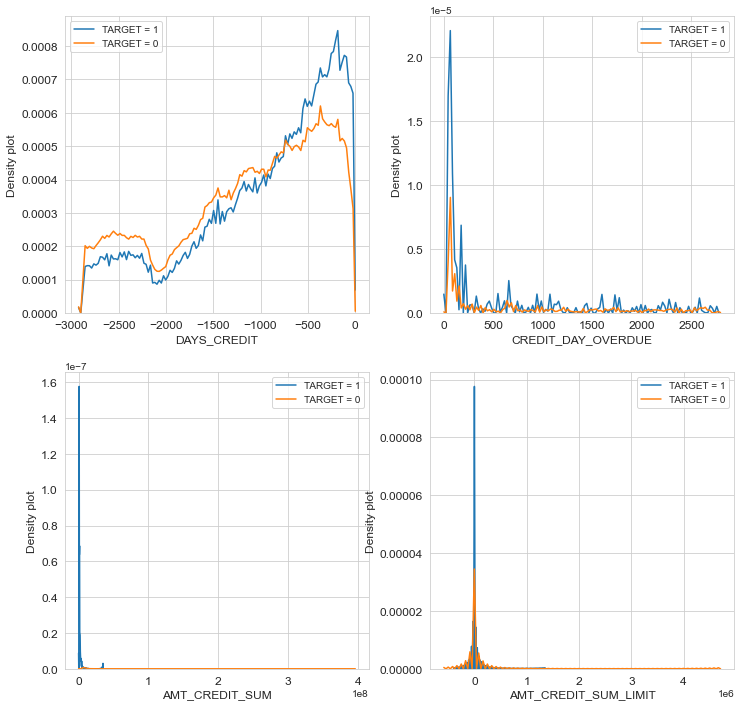

In [75]:
np.warnings.filterwarnings('ignore')
var = ['DAYS_CREDIT','CREDIT_DAY_OVERDUE','AMT_CREDIT_SUM','AMT_CREDIT_SUM_LIMIT']

plot_b_distribution_comp(var, nrow=2)

# Previous application data
The dataframe previous_application contains information about all previous applications for Home Credit loans of clients who have loans in the sample. There is one row for each previous application related to loans in our data sample. SK_ID_CURR is the key connecting application_train|test data with previous_application data.

Let's merge application_train with previous_application.

In [76]:
application_prev_train = app_train.merge(previous_application, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [77]:
print("The resulting dataframe `application_prev_train` has ",application_prev_train.shape[0]," rows and ", 
      application_prev_train.shape[1]," columns.")

The resulting dataframe `application_prev_train` has  1413701  rows and  158  columns.


In [78]:
def plot_p_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_prev_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_prev_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

## Contract type

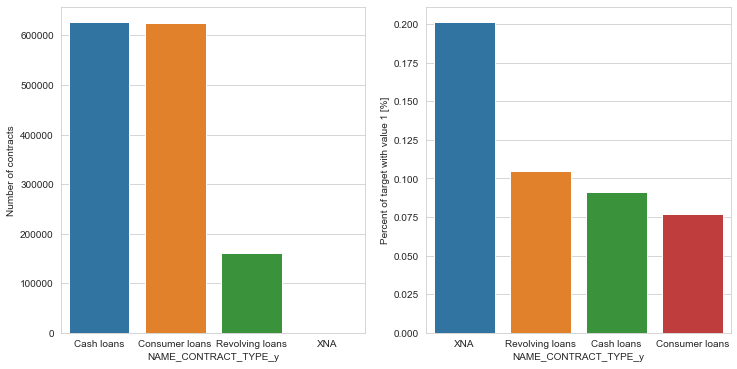

In [79]:
plot_p_stats('NAME_CONTRACT_TYPE_y')

There are three types of contract in the previous application data: *Cash loans*, *Consumer loans*, *Revolving loans*. *Cash loans* and *Consumer loans* are almost the same number (~600K) whilst *Revolving loans* are ~150K.

The percent of defauls loans for clients with previous applications is different for the type of previous applications contracts, decreasing from ~10% for *Revolving loans*, then ~ 9.5% for *Cash loans* and ~8% for *Consumer loans*.

## Cash loan purpose

Let's look to the cash loan purpose, in the case of cash loans.

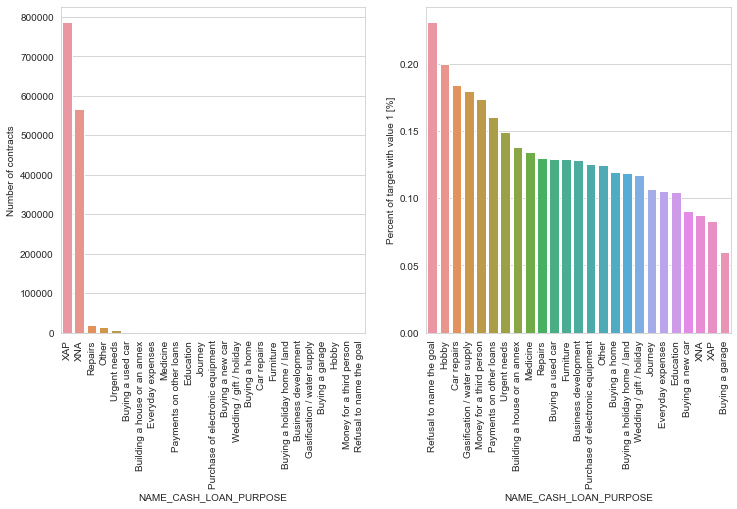

In [80]:
plot_p_stats('NAME_CASH_LOAN_PURPOSE', True, True)

## Contract status

Let's look to the contract status.

Besides not identifed/not available categories, *Repairs*, *Other*, *Urgent needs*, *Buying a used car*, *Building a house or an annex* accounts for the largest number of contracts.


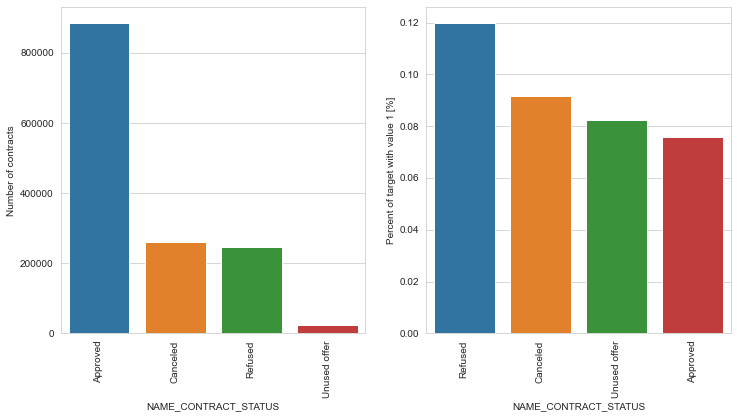

In [81]:
plot_p_stats('NAME_CONTRACT_STATUS', True, True)

Most previous applications contract statuses are Approved (850K), Canceled and Refused (240K). There are only ~20K in status *Unused offer*.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history contract statuses are *Refused* (12%), followed by *Canceled* (9%), *Unused offer* (~8%) and *Approved* (lowest percent of defaults in current applictions, with less than 8%).

## Payment type

Let's check the payment type.

* Most of the previous applications were paid with Cash through the bank (850K). Payments using Non-cash from your account or Cashless from the account of the employer are much rare. These three types of payments in previous applications results in allmost the same percent of defaults for current clients (~8% each).

## Client type

Let's check the client type for previous applications.

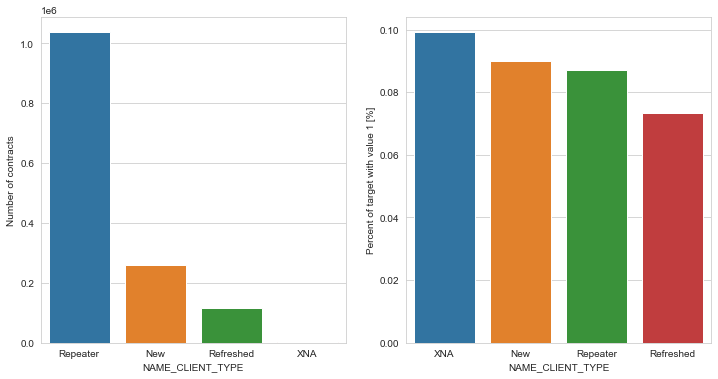

In [82]:
plot_p_stats('NAME_CLIENT_TYPE')

Most of the previous applications have client type *Repeater* (~1M), just over 200K are *New* and ~100K are *Refreshed*.

In terms of default percent for current applications of clients with history of previous applications, current clients with previous applications have values of percent of defaults ranging from from 8.5%, 8.25% and 7% corresponding to client types in the past *New*, *Repeater* and *Refreshed*, respectivelly.

<h3 style="color:green">  The anomalies </h3>

One problem that we always want to watch out for when we perform an EDA is the fact that it has anomalies present in the data. These may be due to incorrectly typed numbers, errors in measurement equipment or may be valid but extreme measurements. One way to quantitatively check for anomalies is to view the statistics for a column using the describe method.

The numbers in the DAYS_BIRTH column are negative because they are saved against the current loan request. To see these statistics in years, we can multiply by -1 and divide by the number of days in the year:

In [83]:
#Reference : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

In [84]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

These data seem normal. There are no outliers for age, either at the top or the bottom. <br>
We now check the attribute DAYS_EMPLOYED that represents the days of employment

In [85]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

The maximum value is around 1000 years and positive

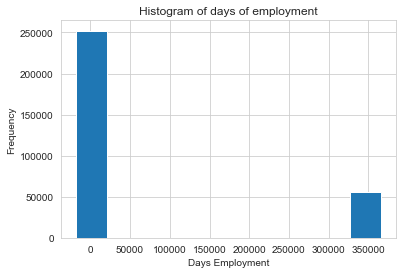

In [86]:
app_train['DAYS_EMPLOYED'].plot.hist(title = "Histogram of days of employment");
plt.xlabel('Days Employment');
plt.show()

Abnormal customers have higher or lower failure rates than the rest of the customers.

In [87]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Note that the anomalies have a low default rate. <br>
The treatment of anomalies depends on the exact situation, without defined rules. One of the safest approaches is to simply define the anomalies on a missing value and then complete them (using imputation) before machine learning. In this case, since all the anomalies have exactly the same value, we want to fill them with the same value in case all these loans share a common element. Abnormal values ​​seem to have some importance, so we want to indicate the machine learning model if we have entered these values ​​correctly. As a solution, we will inform the abnormal values ​​with not a number (np.nan), then create a new Boolean column indicating if the value is abnormal or not.

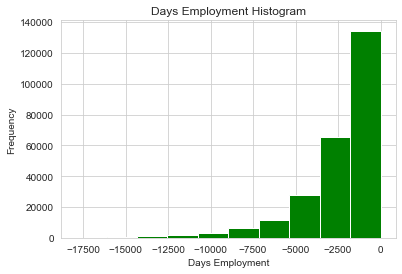

In [88]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram',color='green');
plt.xlabel('Days Employment');
plt.show()

The distribution appears to be much more in line with what we expected, and we have also created a new column to indicate to the model that these values ​​were initially abnormal in the column). The other columns with DAYS in the data frame seem to indicate what we expect, without obvious aberrations.

It is extremely important to note that everything we do with training data must also be applied to the test data. Let's make sure to create the new column and fill the existing column with np.nan in the test data.

In [89]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print("There are% d anomalies in the test data among% d entries" % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data among 48744 entries


<h1 style="color:red"> Pearson correlation of features

### Correlations
After dealing with the categorical variables and outliers, we continue to explore the data. One way to try to understand the data is to look for correlations between the characteristics and the target. <br>
We can calculate the correlation coefficient between each variable and the target using the .corr method that we can apply to a dataframe. <br>
The correlation coefficient is not the most effective method for representing the "relevance" of an entity, but it does give us an idea of ​​the possible relationships within the data. <br>
Here are some general interpretations of the absolute value of the correlation coefficient: <br>

<li> 0.00 to 0.1 ==> very weak </li>
<li> 0.20 to 0.39 ==> low </li>
<li> 0.40 to 0.59 ==> moderate </li>
<li> 0.60 to 0.79 ==> strong </li>
<li> 0.80 to 1.0 ==> very strong </li>

In [90]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645



###### The most significant correlations:
DAYS_BIRTH is the most positive correlation apart from TARGET because the correlation of a variable with itself is always equal to 1. <br>
Looking at the documentation, DAYS_BIRTH is the age in days of the customer at the time of the loan always negative for whatever reason. <br>
The correlation is positive, but the value of this attribute is actually negative, which means that the older the client, the less likely he is to default on his loan (TARGET == 0). <br>
We will therefore take the absolute value of the entity and then the correlation will be negative to obtain a more logical result.

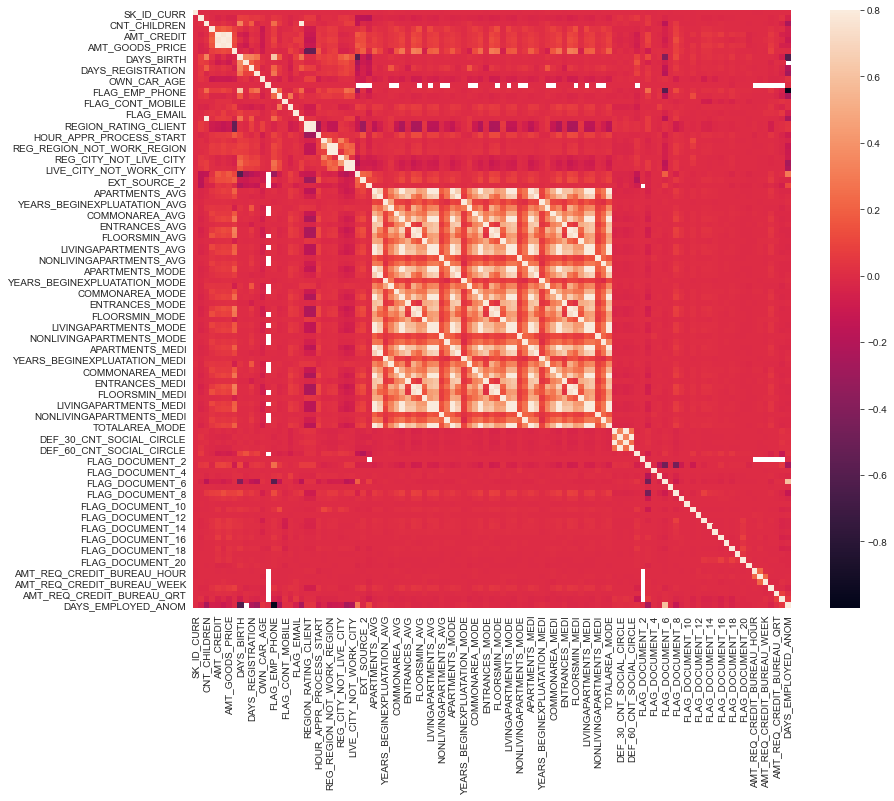

In [91]:
#correlation matrix
corrmat = app_train.corr()
f, ax = plt.subplots(figsize=(14, 11))#12, 9
sns.heatmap(corrmat, vmax=.8, square=True);

## Handling missing values (using Simple Imputer)
    
We need to handle our missing values before we can do any kind of outlier detection. There are many ways to handle missing values. We can use fillna() and replace missing values with data's mean, median or most frequent value. The approach that we shall use below will be Iterative Imputer. Iterative imputer will consider the missing variable to be the dependent variable and all the other features will be independent variables. So there will be a regression and the independent variables will be used gto determine the dependent variable (which is the missing feature).

### For training data

In [92]:
# checking missing data
total = app_train.isnull().sum().sort_values(ascending = False)
percent = (app_train.isnull().sum()/app_train.isnull().count()*100).sort_values(ascending = False)
missing_app_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_app_train_data.head(10)

,Total,Percent
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


#### We are going to delete the features that have a percentage of missing value greater than 25%.

In [93]:
#16
features=app_train[['COMMONAREA_MEDI','COMMONAREA_MODE','COMMONAREA_AVG','NONLIVINGAPARTMENTS_MEDI',
          'NONLIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MODE','LIVINGAPARTMENTS_MODE',
         'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI','FLOORSMIN_AVG','FLOORSMIN_MODE',
          'FLOORSMIN_MEDI','YEARS_BUILD_MODE','YEARS_BUILD_MEDI','YEARS_BUILD_AVG','OWN_CAR_AGE','LANDAREA_MODE','LANDAREA_AVG','LANDAREA_MEDI','BASEMENTAREA_MODE',
                    'BASEMENTAREA_MEDI','BASEMENTAREA_AVG','EXT_SOURCE_1','NONLIVINGAREA_AVG','NONLIVINGAREA_MODE','NONLIVINGAREA_MEDI'
                    ,'ELEVATORS_MODE','ELEVATORS_AVG','ELEVATORS_MEDI','WALLSMATERIAL_MODE','APARTMENTS_AVG','APARTMENTS_MODE',
                    'APARTMENTS_MEDI','ENTRANCES_AVG','ENTRANCES_MODE','ENTRANCES_MEDI','LIVINGAREA_MEDI','LIVINGAREA_MODE','LIVINGAREA_AVG',
                    'HOUSETYPE_MODE','FLOORSMAX_AVG','FLOORSMAX_MODE','FLOORSMAX_MEDI','YEARS_BEGINEXPLUATATION_MODE',
                    'YEARS_BEGINEXPLUATATION_AVG','YEARS_BEGINEXPLUATATION_MEDI','TOTALAREA_MODE','EMERGENCYSTATE_MODE','OCCUPATION_TYPE']]


In [94]:
app_train=app_train.drop(features,axis=1 )

In [95]:
#Training data shape:  

app_train.shape

(307511, 74)

#### Now we will replace the missing values ​​of the other attributes with the method "SimpleImputer" and strategy = 'most_frequent'

In [96]:
#missing values 
from sklearn.impute import SimpleImputer 
columns=app_train.columns
ind=app_train.index
fill_NaN = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
app_train= pd.DataFrame(fill_NaN.fit_transform(app_train))
app_train.columns = columns
app_train.index = ind

In [97]:
# checking missing data
total = app_train.isnull().sum().sort_values(ascending = False)
percent = (app_train.isnull().sum()/app_train.isnull().count()*100).sort_values(ascending = False)
missing_application_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_application_train_data.head()

,Total,Percent
DAYS_EMPLOYED_ANOM,0,0.0
DAYS_EMPLOYED,0,0.0
DAYS_ID_PUBLISH,0,0.0
FLAG_MOBIL,0,0.0
FLAG_EMP_PHONE,0,0.0


We have no more missing values.

### For test data

In [98]:
# checking missing data (64)
total = app_test.isnull().sum().sort_values(ascending = False)
percent = (app_test.isnull().sum()/app_test.isnull().count()*100).sort_values(ascending = False)
missing_app_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_app_test_data.head(20)

,Total,Percent
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
COMMONAREA_MODE,33495,68.716150
NONLIVINGAPARTMENTS_MEDI,33347,68.412523
NONLIVINGAPARTMENTS_AVG,33347,68.412523
NONLIVINGAPARTMENTS_MODE,33347,68.412523
FONDKAPREMONT_MODE,32797,67.284179
LIVINGAPARTMENTS_MODE,32780,67.249302
LIVINGAPARTMENTS_MEDI,32780,67.249302
LIVINGAPARTMENTS_AVG,32780,67.249302


#### We are going to delete the features that have a percentage of missing value greater than 60%.

In [99]:
#16
features=app_test[['COMMONAREA_MEDI','COMMONAREA_MODE','COMMONAREA_AVG','NONLIVINGAPARTMENTS_MEDI',
          'NONLIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MODE','LIVINGAPARTMENTS_MODE',
         'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI','FLOORSMIN_AVG','FLOORSMIN_MODE',
          'FLOORSMIN_MEDI','YEARS_BUILD_MODE','YEARS_BUILD_MEDI','YEARS_BUILD_AVG','OWN_CAR_AGE','LANDAREA_MODE','LANDAREA_AVG','LANDAREA_MEDI','BASEMENTAREA_MODE',
                    'BASEMENTAREA_MEDI','BASEMENTAREA_AVG','EXT_SOURCE_1','NONLIVINGAREA_AVG','NONLIVINGAREA_MODE','NONLIVINGAREA_MEDI'
                    ,'ELEVATORS_MODE','ELEVATORS_AVG','ELEVATORS_MEDI','WALLSMATERIAL_MODE','APARTMENTS_AVG','APARTMENTS_MODE',
                    'APARTMENTS_MEDI','ENTRANCES_AVG','ENTRANCES_MODE','ENTRANCES_MEDI','LIVINGAREA_MEDI','LIVINGAREA_MODE','LIVINGAREA_AVG',
                    'HOUSETYPE_MODE','FLOORSMAX_AVG','FLOORSMAX_MODE','FLOORSMAX_MEDI','YEARS_BEGINEXPLUATATION_MODE',
                    'YEARS_BEGINEXPLUATATION_AVG','YEARS_BEGINEXPLUATATION_MEDI','TOTALAREA_MODE','EMERGENCYSTATE_MODE','OCCUPATION_TYPE']]


In [100]:
app_test=app_test.drop(features,axis=1)

In [101]:
#Training data shape: 
app_test.shape

(48744, 73)

#### Now we will replace the missing values ​​of the other attributes with the method "Imputer" and strategy = 'most_frequent'

In [102]:
#missing values
columns=app_test.columns
ind=app_test.index
fill_NaN = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
app_test= pd.DataFrame(fill_NaN.fit_transform(app_test))
app_test.columns = columns
app_test.index = ind

In [103]:
# checking missing data
total = app_test.isnull().sum().sort_values(ascending = False)
percent = (app_test.isnull().sum()/app_test.isnull().count()*100).sort_values(ascending = False)
missing_application_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_application_test_data.head()

,Total,Percent
DAYS_EMPLOYED_ANOM,0,0.0
REG_CITY_NOT_WORK_CITY,0,0.0
DAYS_ID_PUBLISH,0,0.0
FLAG_MOBIL,0,0.0
FLAG_EMP_PHONE,0,0.0


## Alignment of Training and Test data
The same attributes (columns) must appear in the training and test data. One-hot encoding created more columns in the training data than in the test data, because some categorical variables had categories not represented in the test data. To remove the attributes of the training data which are not included in the test data, the dataframes must be aligned. <br>
First, we will extract the target column from the training data (because it is not in the test data, but we will keep this data). When we do the alignment, we must make sure to set axis = 1 to align the dataframes according to the columns and not the lines!

In [2]:
app_train = pd.read_csv('app_train.csv')
app_test = pd.read_csv('app_test.csv')

app_train.drop(app_train[app_train['CODE_GENDER'] == 'XNA'].index, axis = 0, inplace=True )

# We store the TARGET column in the variable train_labels
train_labels = app_train['TARGET']

#We align the training and test data, We keep that the columns present in the two dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307507, 75)
Testing Features shape:  (48744, 74)


In [105]:
app_train.to_csv('app_train.csv')
app_test.to_csv('app_test.csv')

In [9]:
app_train= pd.read_csv("app_train.csv")
app_test=pd.read_csv('app_test.csv')

In [4]:
app_train

,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,TARGET
0,0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False,1
1,1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,0
2,2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,0
3,3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,0
4,4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,456251,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,0
307507,307507,456252,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
307508,307508,456253,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,1.0,0.0,0.0,1.0,0.0,1.0,False,0
307509,307509,456254,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,1


##  Feature Engineering

In [159]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb

app_test['is_test'] = 1 
app_test['is_train'] = 0
app_train['is_test'] = 0
app_train['is_train'] = 1

# target variable
Y = app_train['TARGET']
train_X = app_train.drop(['TARGET'], axis = 1)

# test ID
test_id = app_test['SK_ID_CURR']
test_X = app_test

# merge train and test datasets for preprocessing
data = pd.concat([train_X, test_X], axis=0)

In [129]:
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

In [160]:
data_c = _get_categorical_features(pd.read_csv('app_train.csv'))

In [162]:
data_c

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE']

## Feature Engineering - Previous Applications
- Credits to excellent kernel shared by Olivier for more ideas: https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm

In [164]:
## More Feature Ideas Reference : https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm 

## count the number of previous applications for a given ID
prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application['SK_ID_PREV'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

## Average values for all other features in previous applications
prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')

In [167]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,p_RATE_INTEREST_PRIVILEGED,p_DAYS_DECISION,p_SELLERPLACE_AREA,p_CNT_PAYMENT,p_DAYS_FIRST_DRAWING,p_DAYS_FIRST_DUE,p_DAYS_LAST_DUE_1ST_VERSION,p_DAYS_LAST_DUE,p_DAYS_TERMINATION,p_NFLAG_INSURED_ON_APPROVAL
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,NaN,-606.000000,500.000000,24.000000,365243.0,-565.000000,125.000000,-25.000000,-17.000000,0.000000
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,-1305.000000,533.000000,10.000000,365243.0,-1274.333333,-1004.333333,-1054.333333,-1047.333333,0.666667
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,NaN,-815.000000,30.000000,4.000000,365243.0,-784.000000,-694.000000,-724.000000,-714.000000,0.000000
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,-272.444444,894.222222,23.000000,365243.0,91066.500000,91584.000000,182477.500000,182481.750000,0.000000
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,-1222.833333,409.166667,20.666667,365243.0,-1263.200000,-837.200000,72136.200000,72143.800000,0.600000


##  Feature Engineering - Bureau Data

In [168]:
# Average Values for all bureau features 
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['buro_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]
data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')


## Feature Engineering - Previous Installments

In [169]:
## count the number of previous installments
cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
installments_payments['SK_ID_PREV'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])

## Average values for all other variables in installments payments
avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]
data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

##  Feature Engineering - Pos Cash Balance

In [170]:
### count the number of pos cash for a given ID
pcb_count = POS_CASH_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
POS_CASH_balance['SK_ID_PREV'] = POS_CASH_balance['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])

## Average Values for all other variables in pos cash
pcb_avg = POS_CASH_balance.groupby('SK_ID_CURR').mean()
data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')

##  Feature Engineering - Credit Card Balance

In [171]:
### count the number of previous applications for a given ID
nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_balance['SK_ID_PREV'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

### average of all other columns 
avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

In [172]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_AMT_RECEIVABLE_PRINCIPAL,cc_bal_AMT_RECIVABLE,cc_bal_AMT_TOTAL_RECEIVABLE,cc_bal_CNT_DRAWINGS_ATM_CURRENT,cc_bal_CNT_DRAWINGS_CURRENT,cc_bal_CNT_DRAWINGS_OTHER_CURRENT,cc_bal_CNT_DRAWINGS_POS_CURRENT,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
data.to_csv("data.csv",index=False)

In [174]:
column_with_nan = data.columns[data.isnull().any()]
for column in column_with_nan:
    if data[column].isnull().sum()*100.0/data.shape[0] > 25:
        data.drop(column,1, inplace=True)

In [178]:
columns=data.columns
ind=data.index
fill_NaN = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data= pd.DataFrame(fill_NaN.fit_transform(data))
data.columns = columns
data.index = ind

Here we are removing column who is having more than 25 % NAN values in its column and replacng the rest of NAN values with most frequent using simple imputer.

In [179]:
data.to_csv("data.csv",index=False)

In [180]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,i_DAYS_INSTALMENT,i_DAYS_ENTRY_PAYMENT,i_AMT_INSTALMENT,i_AMT_PAYMENT,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
0,100002,Cash loans,M,N,Y,0,202500,406598,24700.5,351000,...,-295,-315.421,11559.2,11559.2,19,-10,24,15,0,0
1,100003,Cash loans,F,N,N,0,270000,1.2935e+06,35698.5,1.1295e+06,...,-1378.16,-1385.32,64754.6,64754.6,28,-43.7857,10.1071,5.78571,0,0
2,100004,Revolving loans,M,Y,Y,0,67500,135000,6750,135000,...,-754,-761.667,7096.15,7096.15,4,-25.5,3.75,2.25,0,0
3,100006,Cash loans,F,N,Y,0,135000,312682,29686.5,297000,...,-252.25,-271.625,62947.1,62947.1,21,-9.61905,12,8.65,0,0
4,100007,Cash loans,M,N,Y,0,121500,513000,21865.5,513000,...,-1028.61,-1032.24,12666.4,12214.1,66,-33.6364,15.3333,8.9697,0,0


We will have to deal with categorical variables. Unfortunately, a machine learning model cannot handle categorical variables (with the exception of some models such as LightGBM). We must then find a way to represent these variables as numbers before transferring them to the model. There are two main ways to carry out this process: <br>
#### 1 - Label encoding:
Each unique category is assigned in a categorical variable with an integer. (No new column is created).

In [181]:
# Create a label encoder object 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
count = 0

# browse the attributes of app_train
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform both training and testing data
            data[col] = le.transform(data[col])
            
            # Keep track of how many columns were label encoded
            count += 1
            
print('%d columns were label encoded.' % count)

39 columns were label encoded.


In [182]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,i_DAYS_INSTALMENT,i_DAYS_ENTRY_PAYMENT,i_AMT_INSTALMENT,i_AMT_PAYMENT,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
0,100002,0,1,0,1,0,202500,406598,24700.5,351000,...,-295,-315.421,11559.2,11559.2,19,-10,24,15,0,0
1,100003,0,0,0,0,0,270000,1.2935e+06,35698.5,1.1295e+06,...,-1378.16,-1385.32,64754.6,64754.6,28,-43.7857,10.1071,5.78571,0,0
2,100004,1,1,1,1,0,67500,135000,6750,135000,...,-754,-761.667,7096.15,7096.15,4,-25.5,3.75,2.25,0,0
3,100006,0,0,0,1,0,135000,312682,29686.5,297000,...,-252.25,-271.625,62947.1,62947.1,21,-9.61905,12,8.65,0,0
4,100007,0,1,0,1,0,121500,513000,21865.5,513000,...,-1028.61,-1032.24,12666.4,12214.1,66,-33.6364,15.3333,8.9697,0,0


#### 2 - One-hot encoding:
A new column is created for each unique category in a categorical variable. Each observation receives a 1 in the column for the corresponding category and a 0 in all the other new columns.

In [183]:
# function to obtain Categorical Features
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# function to factorize categorical features
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# function to create dummy variables of categorical features
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

# get categorical features
#data_cats = _get_categorical_features(data)
prev_app_cats = _get_categorical_features(previous_application)
bureau_cats = _get_categorical_features(bureau)
pcb_cats = _get_categorical_features(POS_CASH_balance)
ccbal_cats = _get_categorical_features(credit_card_balance)

# create additional dummy features - 
previous_application = _get_dummies(previous_application, prev_app_cats)
bureau = _get_dummies(bureau, bureau_cats)
pcb = _get_dummies(POS_CASH_balance, pcb_cats)
credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)
data = _get_dummies(data, data_cats)


# factorize the categorical features from train and test data
data = _factorize_categoricals(data, data_cats)

In [184]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account
0,100002,0,0,0,0,0,202500,406598,24700.5,351000,...,0,0,0,0,0,0,0,0,1,0
1,100003,0,1,0,1,0,270000,1.2935e+06,35698.5,1.1295e+06,...,0,0,0,0,0,0,0,0,1,0
2,100004,1,0,1,0,0,67500,135000,6750,135000,...,0,0,0,0,0,0,0,0,1,0
3,100006,0,1,0,0,0,135000,312682,29686.5,297000,...,0,0,0,0,0,0,0,0,1,0
4,100007,0,0,0,0,0,121500,513000,21865.5,513000,...,0,0,0,0,0,0,0,0,1,0


In [185]:
data.to_csv('data_final.csv')